In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

pd.set_option("display.max_columns",30)

# Functions

In [2]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

def apply_aggregation(df):
    """
    Resample the DataFrame to hourly intervals and apply custom aggregation.
    """
    df = df.replace(-999.99, np.nan)

    # Replace 0.0 values with NaN and apply range filter for 'mcp9808' column
    if 'mcp9808' in df.columns:
        df['mcp9808'] = df['mcp9808'].replace(0.0, np.nan)
        df['mcp9808'] = df['mcp9808'].apply(lambda x: x if -45 <= x <= 45 else np.nan)

    # Dictionary to store custom aggregations for each variable
    aggregation_dict = {var: custom_aggregation(var) for var in df.columns}

    # Resample DataFrame to hourly intervals and apply custom aggregation for each variable
    hourly_df = df.resample('h').apply(lambda x: pd.Series({var: func(x[var]) for var, func in aggregation_dict.items()}))

    return hourly_df


In [3]:
def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          era5_ds=None, 
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]
    if era5_ds:
        # Extract ERA5 data for the specified location and time window
        era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
        era5_filtered = era5_data.sel(time=slice(start_time, end_time))
        era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if variable_hourly == "tipping": 
        unit = "mm"
    elif variable_hourly == "wind_speed":
        unit = "m/s"
    else:
        unit = "°C"

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            plt.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in {unit}", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in {unit} (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            # Create secondary y-axis for ERA5 data
            ax2 = ax1.twinx()
            ax2.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')
            ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in {unit}", fontsize=12)
            ax2.tick_params(axis='y')

            # Combine legends from both axes
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()

In [4]:
def statistics(df, hourly = True): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    zero_measurements = (df == 0).sum()
    nan_count = df.isna().sum()
    
    non_zero_measurements = actual_measurements - zero_measurements
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    nonzerorelativetoactual = non_zero_measurements / actual_measurements * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    print(f"Non-zero relative to actual: {nonzerorelativetoactual:.2f}%")
    print(f"Zero measurements: {zero_measurements}")
    print(f"NaN measurements: {nan_count}")

In [5]:
def plot_hist(df, var_name, station, save=False, log=False):

    if var_name == 'tipping': 
        var_name_plot = 'precipitation'
    elif var_name == 'mcp9808':
        var_name_plot = 'temperature'
    elif var_name == 'htu_hum':
        var_name_plot = 'humidity'
    elif var_name == 'bmp280_pres':
        var_name_plot = 'pressure'
    else:
        var_name_plot = var_name

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=log, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name_plot.capitalize()} Bins")
    plt.ylabel("Count")
    plt.title(f"{station.capitalize()}: Histogram of {var_name_plot.capitalize()}")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()


In [6]:
def plot_variable_over_time(df, var_name, year=None, title_add_on = None):
    """
    Plots a specified variable over time from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data with a datetime index.
    variable (str): The name of the column to plot.
    year (int, optional): The specific year to plot. If None, plots all available data.
    """
    # Check if the variable exists in the DataFrame
    if var_name not in df.columns:
        raise ValueError(f"Variable '{var_name}' not found in DataFrame columns.")
    
    if var_name == 'tipping': 
        var_name_plot = 'precipitation'
        unit = "mm"
    elif var_name == 'mcp9808':
        var_name_plot = 'temperature'
        unit = "°C"
    elif var_name == 'htu_hum':
        var_name_plot = 'humidity'
        unit = "%"
    elif var_name == 'bmp280_pres':
        var_name_plot = 'pressure'
        unit = "hPa"
    else:
        var_name_plot = var_name
        unit = ""
    # Filter by year if specified
    if year is not None:
        df = df[df.index.year == year]
    
    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df[var_name], marker = "x", label=f"{var_name} over time", color='green')
    plt.title(f"{var_name_plot.capitalize()} {title_add_on} Over Time in {unit}" + (f" in {year}" if year else ""))
    plt.xlabel("Date")
    plt.xticks(rotation=45)  # Rotate x-axis values

    plt.ylabel(f"{var_name_plot.capitalize()} in {unit}")
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

# Example usage:
# df should be a DataFrame with a datetime index and a column named 'temperature' (or any chosen variable).
# plot_variable_over_time(df, 'temperature', year=2023)


# Analysis

## Overview

In [7]:
barbados_processed_df = pd.read_csv("station_data_processed/barbados_hourly_processed_data.csv", index_col=0)
barbados_processed_df.index = pd.to_datetime(barbados_processed_df.index, errors='coerce')

# Apply the  aggregation
barbados_hourly_df = apply_aggregation(barbados_processed_df)

In [10]:
barbados_hourly_df = pd.read_csv("station_data_processed/barbados_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)


In [9]:
barbados_hourly_df.dropna(how='all', axis=1, inplace=True) 
barbados_hourly_df.to_csv("station_data_processed/barbados_hourly_aggregated_data.csv", index=True)
print(barbados_hourly_df.index)
print(barbados_hourly_df.index.dtype)

DatetimeIndex(['2020-06-08 15:00:00', '2020-06-08 16:00:00',
               '2020-06-08 17:00:00', '2020-06-08 18:00:00',
               '2020-06-08 19:00:00', '2020-06-08 20:00:00',
               '2020-06-08 21:00:00', '2020-06-08 22:00:00',
               '2020-06-08 23:00:00', '2020-06-09 00:00:00',
               ...
               '2023-11-22 10:00:00', '2023-11-22 11:00:00',
               '2023-11-22 12:00:00', '2023-11-22 13:00:00',
               '2023-11-22 14:00:00', '2023-11-22 15:00:00',
               '2023-11-22 16:00:00', '2023-11-22 17:00:00',
               '2023-11-22 18:00:00', '2023-11-22 19:00:00'],
              dtype='datetime64[ns]', name='datetime', length=30293, freq='h')
datetime64[ns]


In [11]:
barbados_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30293 entries, 2020-06-08 15:00:00 to 2023-11-22 19:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bmp280_temp  19275 non-null  float64
 1   bmp280_pres  19304 non-null  float64
 2   bmp280_slp   19304 non-null  float64
 3   htu_temp     19539 non-null  float64
 4   htu_hum      15417 non-null  float64
 5   mcp9808      17315 non-null  float64
 6   tipping      29008 non-null  float64
 7   vis_light    22612 non-null  float64
 8   ir_light     21491 non-null  float64
 9   uv_light     13230 non-null  float64
 10  wind_speed   26956 non-null  float64
dtypes: float64(11)
memory usage: 2.8 MB


In [12]:
barbados_hourly_df.describe()

,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
count,19275.000000,19304.000000,19304.000000,19539.000000,15417.000000,17315.000000,29008.000000,22612.000000,21491.000000,13230.000000,26956.000000
mean,26.363526,984.414959,1015.581027,22.188743,85.960735,25.587465,0.193285,419.594529,1990.336373,147.866062,3.065972
std,1.966420,11.590826,11.953170,6.201811,8.186707,2.002858,1.341190,228.350229,2400.179046,129.135906,2.429038
min,-21.155000,648.600000,669.320000,1.500000,55.900000,19.800000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,24.975000,983.830000,1014.975000,21.900000,80.150000,24.200000,0.000000,260.000000,253.500000,29.000000,1.963417
50%,26.160000,985.000000,1016.210000,24.400000,86.900000,25.400000,0.000000,266.500000,499.000000,124.500000,2.895667
75%,27.660000,986.125000,1017.370000,26.200000,92.550000,27.100000,0.000000,536.625000,3262.250000,227.000000,3.824583
max,33.410000,990.780000,1021.940000,31.100000,99.800000,32.200000,66.200000,1221.000000,10258.500000,516.500000,74.617241


## Statistics

In [13]:
summary = statistics(barbados_hourly_df["mcp9808"])


Total hours: 30293
Total hours: 100%
Actual measurements: 17315
Relative measurements: 57.16%
Non-zero measurements: 17315
Relative non-zero measurements: 57.16%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 12978


In [14]:
summary = statistics(barbados_hourly_df["tipping"])


Total hours: 30293
Total hours: 100%
Actual measurements: 29008
Relative measurements: 95.76%
Non-zero measurements: 2868
Relative non-zero measurements: 9.47%
Non-zero relative to actual: 9.89%
Zero measurements: 26140
NaN measurements: 1285


In [15]:
summary = statistics(barbados_hourly_df["wind_speed"])


Total hours: 30293
Total hours: 100%
Actual measurements: 26956
Relative measurements: 88.98%
Non-zero measurements: 26956
Relative non-zero measurements: 88.98%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 3337


In [17]:
summary = statistics(barbados_hourly_df["bmp280_pres"])


Total hours: 30293
Total hours: 100%
Actual measurements: 19304
Relative measurements: 63.72%
Non-zero measurements: 19304
Relative non-zero measurements: 63.72%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 10989


In [18]:
summary = statistics(barbados_hourly_df["htu_hum"])


Total hours: 30293
Total hours: 100%
Actual measurements: 15417
Relative measurements: 50.89%
Non-zero measurements: 15417
Relative non-zero measurements: 50.89%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 14876


## Histogram

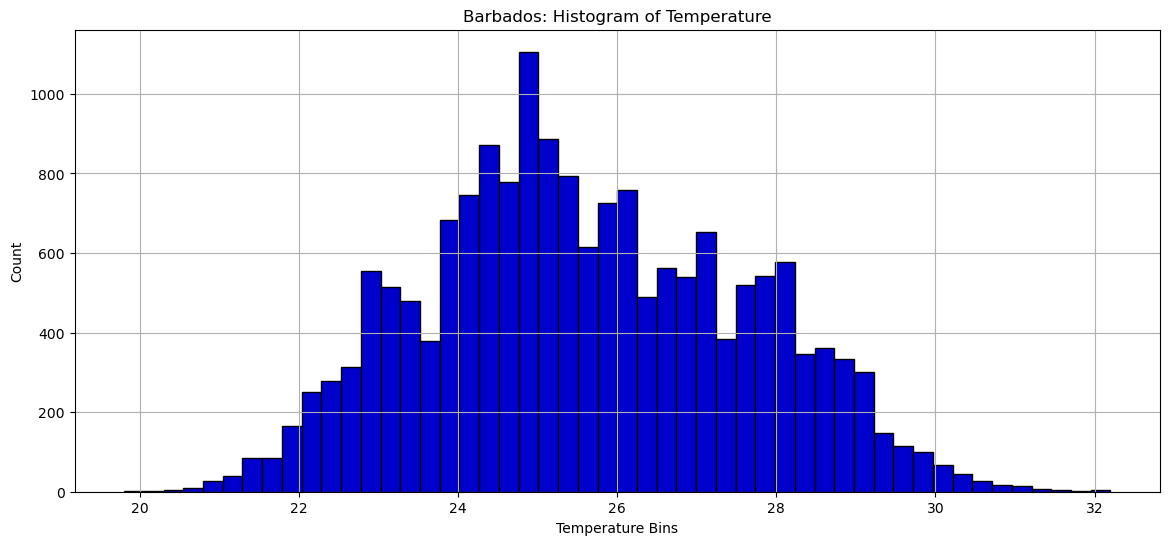

In [19]:
plot_hist(barbados_hourly_df, "mcp9808", "Barbados", save=False)

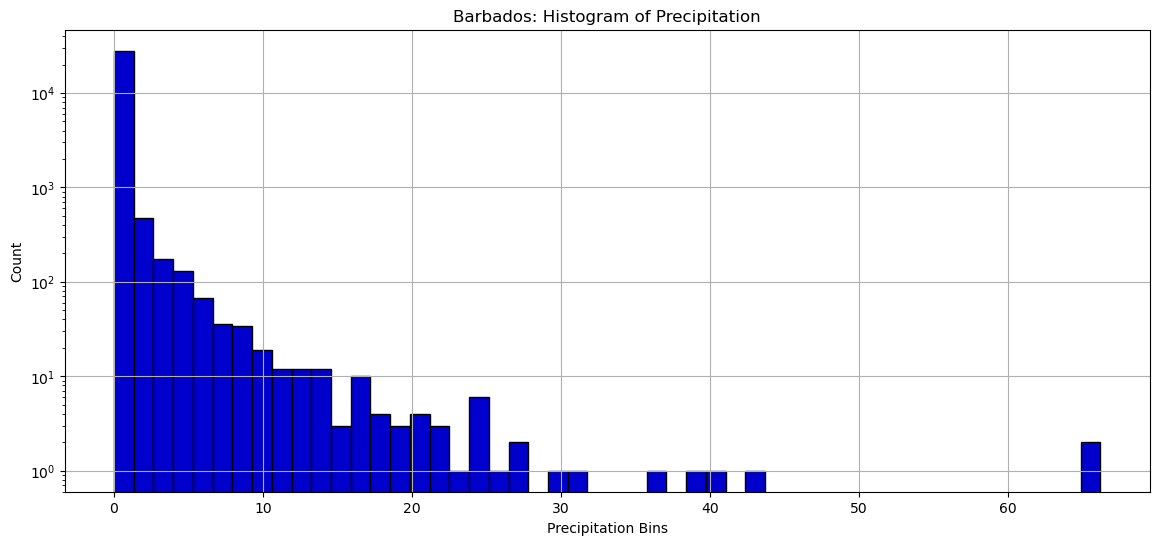

In [20]:
plot_hist(barbados_hourly_df, "tipping", "Barbados", save=False, log=True)

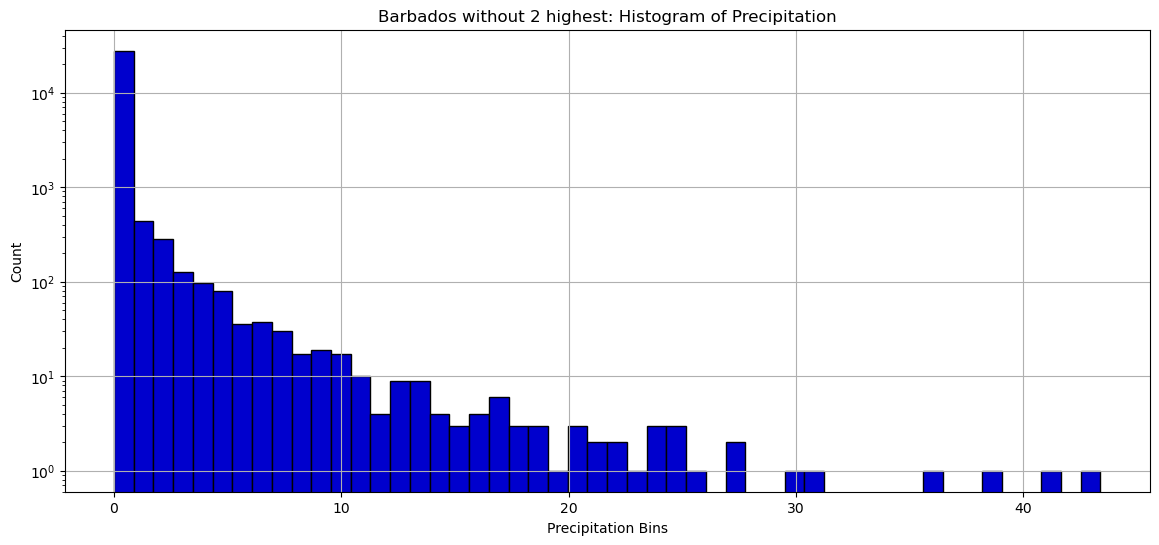

In [21]:
x = 2  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
df_dropped = barbados_hourly_df.sort_values(by="tipping", ascending=False).iloc[x:]

# Reset index if needed
df_dropped = df_dropped.reset_index(drop=True)

plot_hist(df_dropped, "tipping", "Barbados without 2 highest", save=False, log=True)

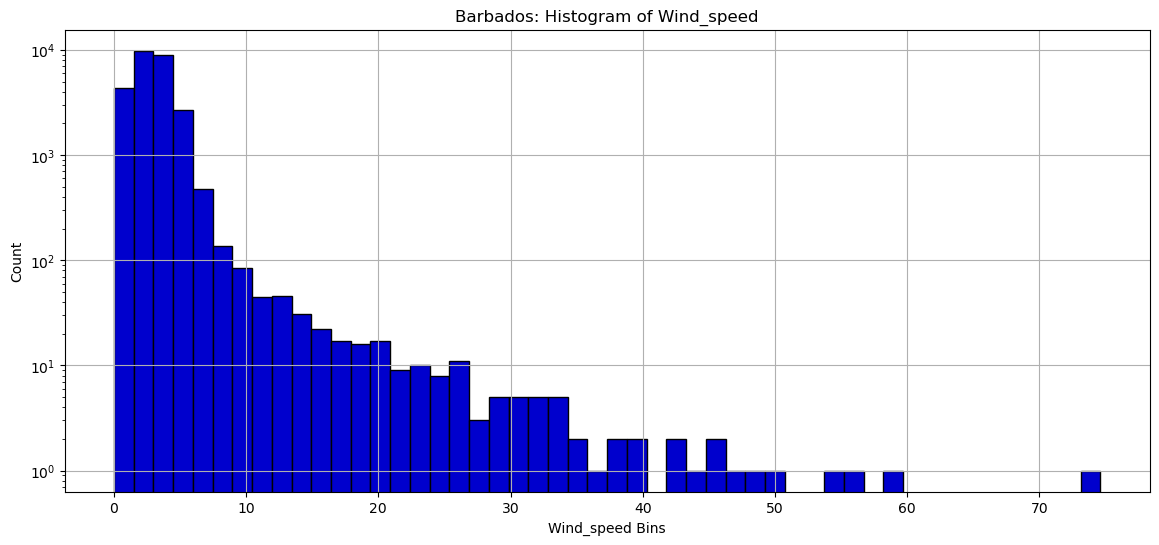

In [23]:
plot_hist(barbados_hourly_df, "wind_speed", "Barbados", save=False, log=True)

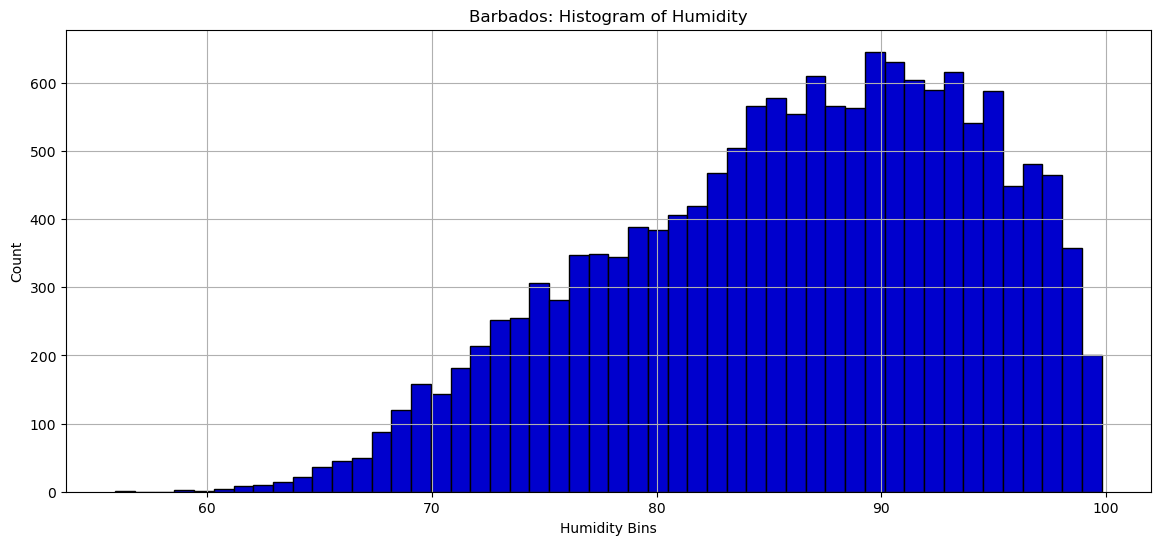

In [39]:
plot_hist(barbados_hourly_df, "htu_hum", "Barbados", save=False, log=False)

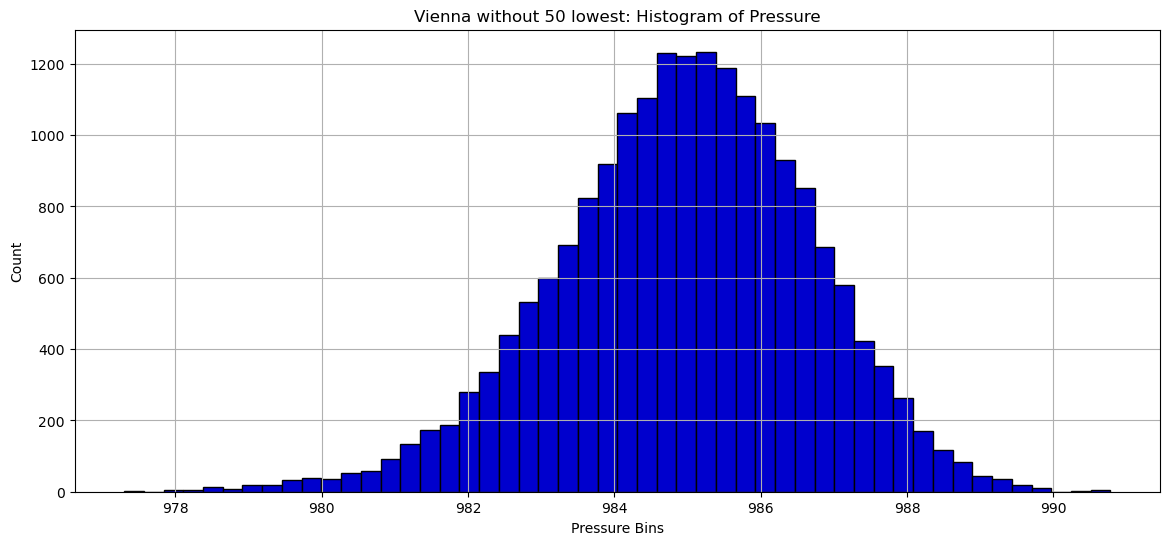

In [55]:
x = 50 # Number of rows to drop below lowest measurments

# Sort by the column in descending order and drop the top x rows
df_dropped = barbados_hourly_df.sort_values(by="bmp280_pres", ascending=True).iloc[x:]

# Reset index if needed
df_dropped = df_dropped.reset_index(drop=True)

plot_hist(df_dropped, "bmp280_pres", "Vienna without 50 lowest", save=False, log=False)


## Overview Plots

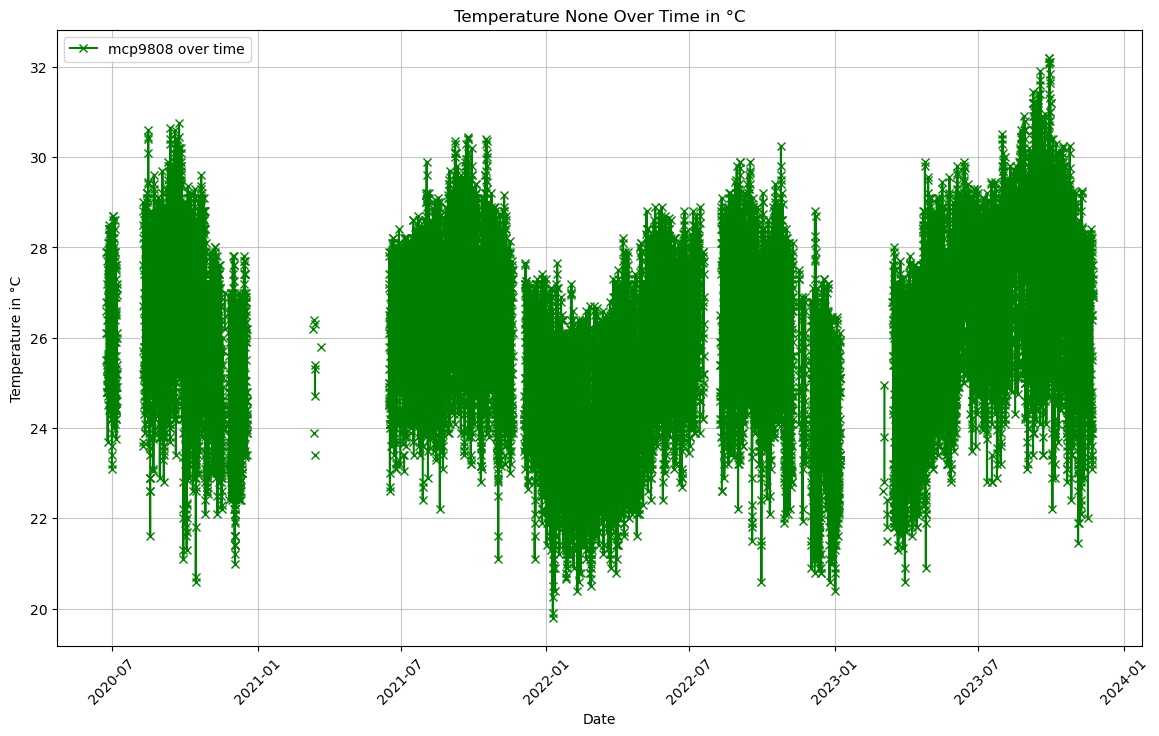

In [56]:
plot_variable_over_time(barbados_hourly_df, "mcp9808", year=None)


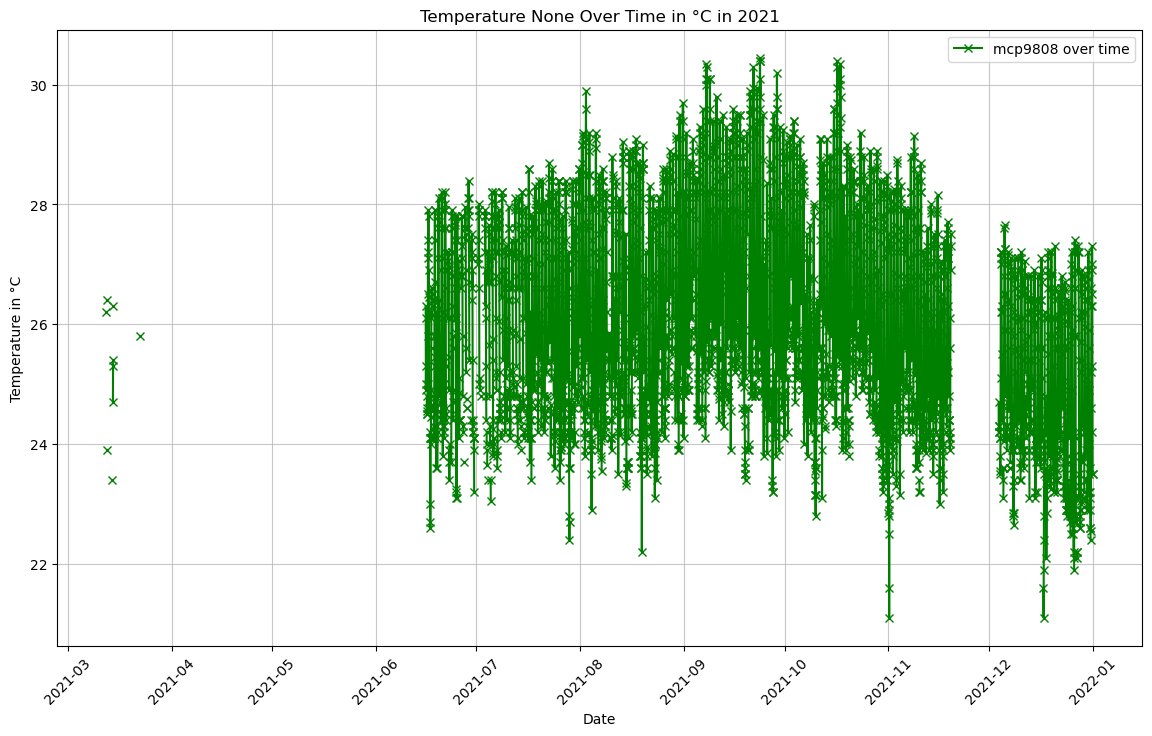

In [57]:
plot_variable_over_time(barbados_hourly_df, "mcp9808", year=2021)


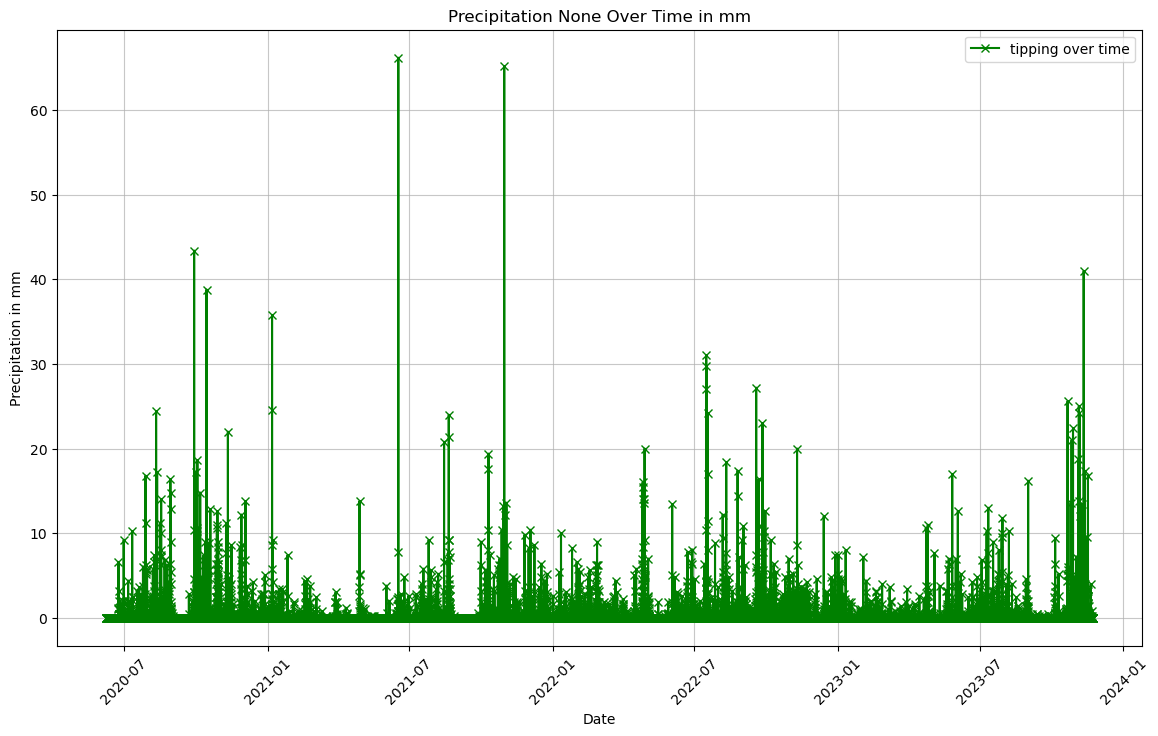

In [58]:
plot_variable_over_time(barbados_hourly_df, "tipping", year=None)


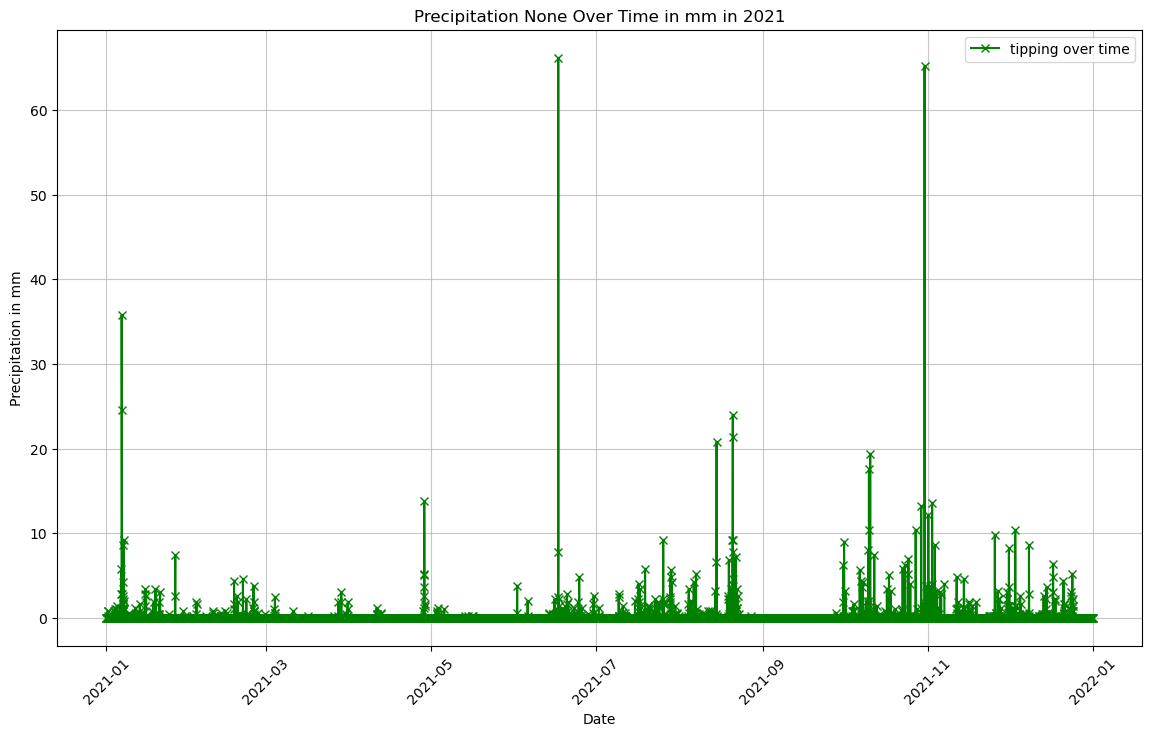

In [59]:
plot_variable_over_time(barbados_hourly_df, "tipping", year=2021)


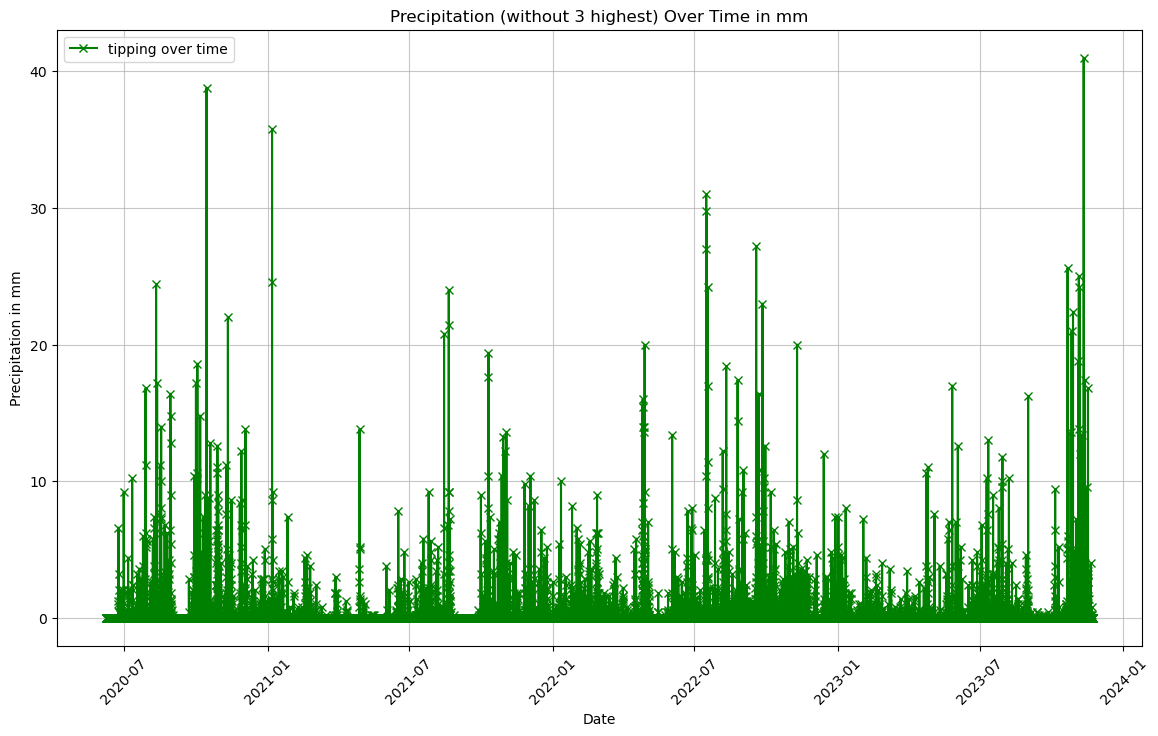

In [61]:
x = 3  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
top_values = barbados_hourly_df["tipping"].nlargest(x).values
df_filtered = barbados_hourly_df[~barbados_hourly_df["tipping"].isin(top_values)]

plot_variable_over_time(df_filtered, "tipping", year=None, title_add_on="(without 3 highest)")


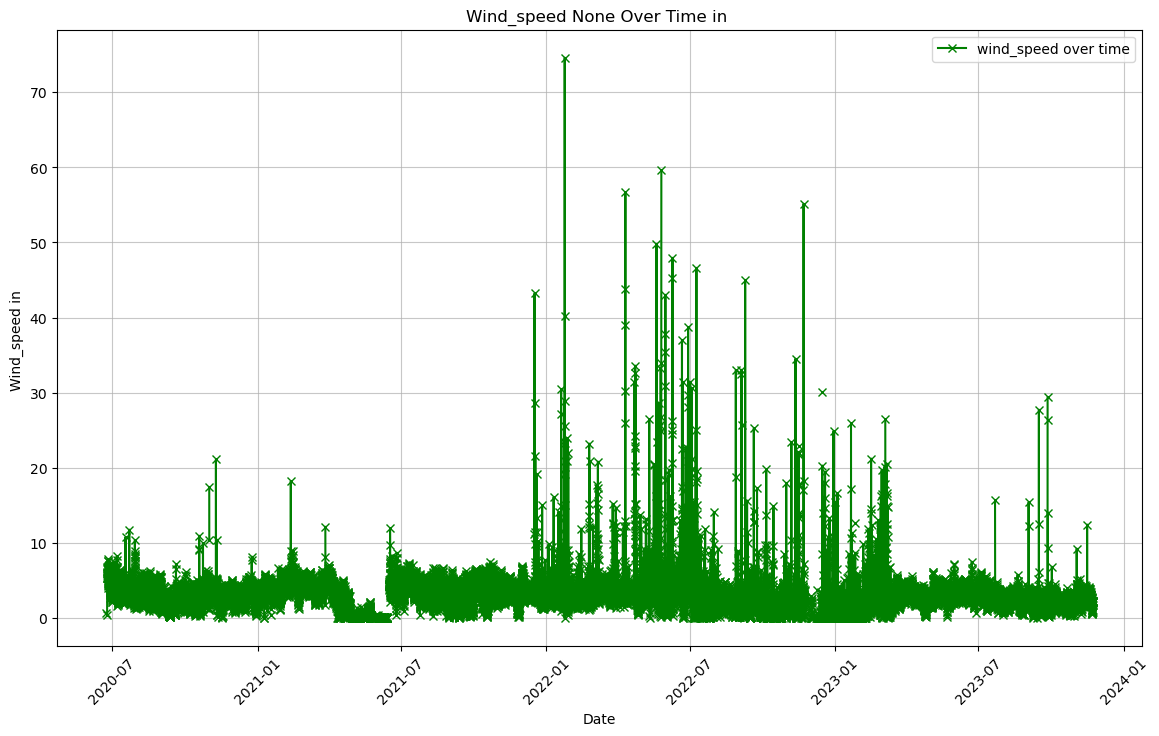

In [62]:
plot_variable_over_time(barbados_hourly_df, "wind_speed", year=None)


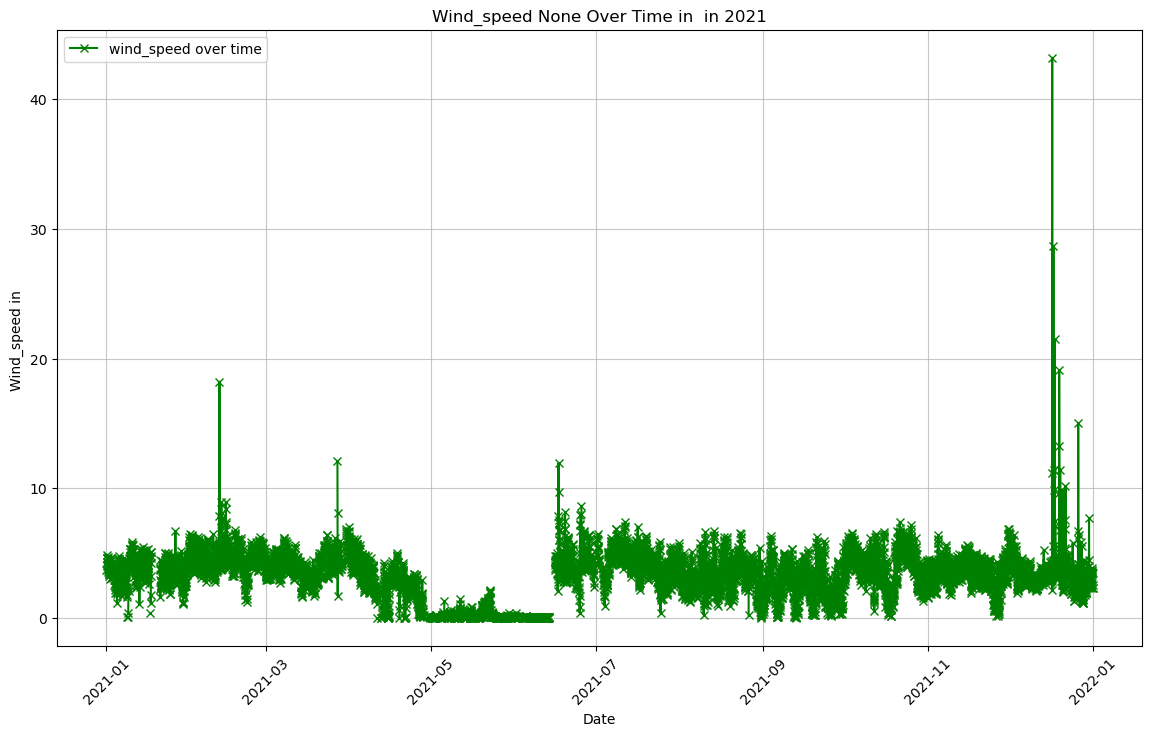

In [65]:
plot_variable_over_time(barbados_hourly_df, "wind_speed", year=2021)


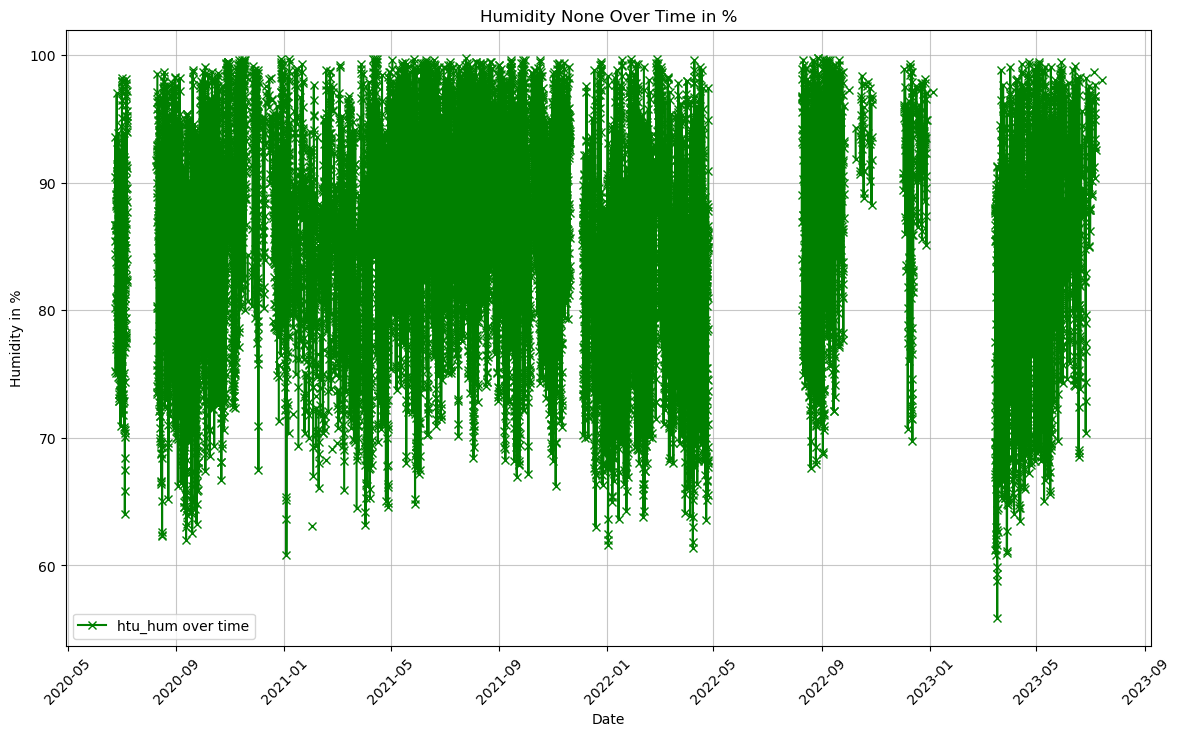

In [66]:
plot_variable_over_time(barbados_hourly_df, "htu_hum", year=None)


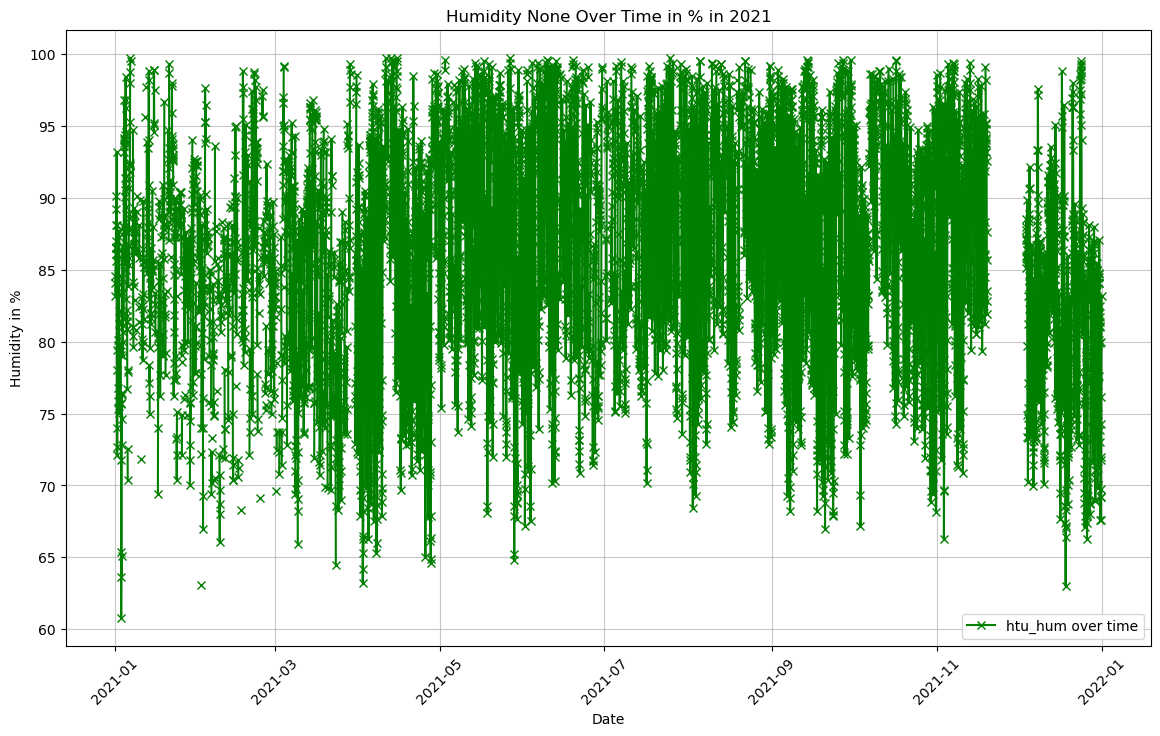

In [67]:
plot_variable_over_time(barbados_hourly_df, "htu_hum", year=2021)


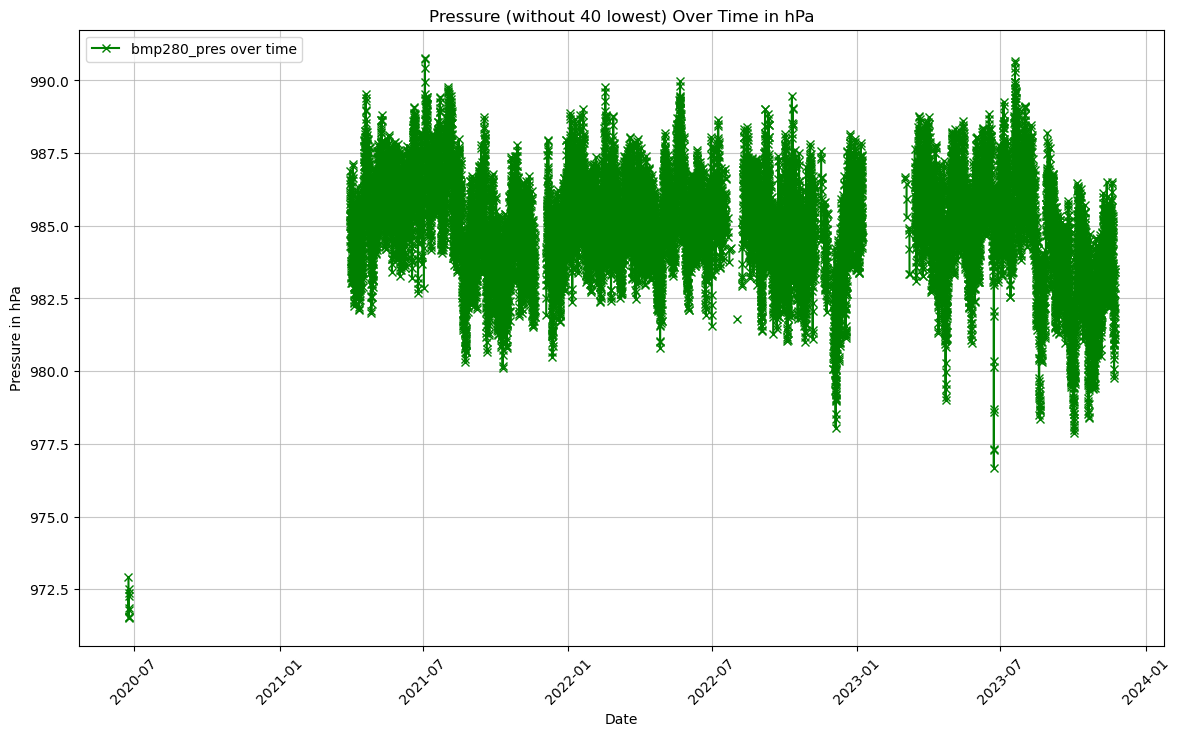

In [71]:

x = 40  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
top_values = barbados_hourly_df["bmp280_pres"].nsmallest(x).values
df_filtered = barbados_hourly_df[~barbados_hourly_df["bmp280_pres"].isin(top_values)]

plot_variable_over_time(df_filtered, "bmp280_pres", year=None, title_add_on="(without 40 lowest)")

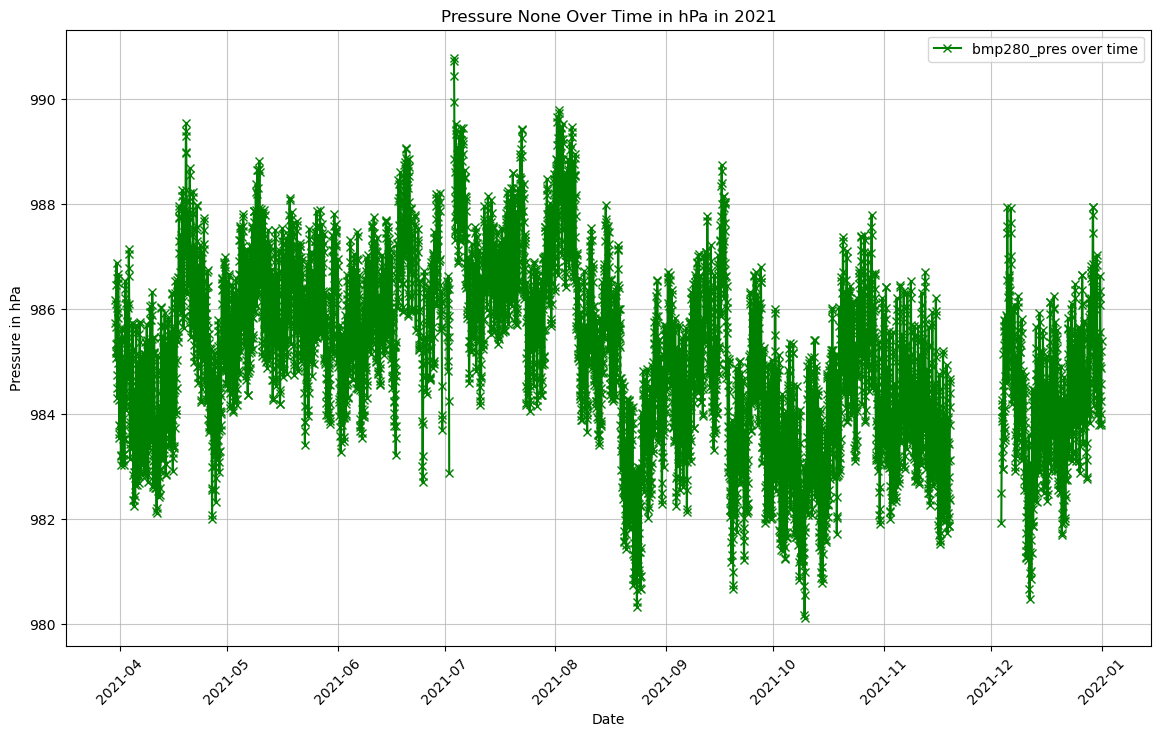

In [72]:
plot_variable_over_time(df_filtered, "bmp280_pres", year=2021)

# Events

In [73]:
def rename_variables(ds):
    variable_mapping = {
        'var167': 't2m',      # 2 metre temperature
        'var228': 'tp',       # Total precipitation
        'var165': 'u10',      # 10 metre U wind component
        'var166': 'v10',      # 10 metre V wind component
        # Add other mappings as needed
    }
    variables_to_rename = {var: new_var for var, new_var in variable_mapping.items() if var in ds.variables}
    ds = ds.rename(variables_to_rename)
    return ds

def scale_variables(ds):
    ds["t2m"].values = ds["t2m"].values - 273.15
    ds["tp"].values = ds["tp"].values * 1000
    u10 = ds['u10']
    v10 = ds['v10']
    wind_speed = np.sqrt(u10 ** 2 + v10 ** 2)
    ds['wind_speed'] = wind_speed
    return ds

def convert_grib_to_nc( source_path):
    nc_copied_path = "converted_" + source_path 
    cdo_command = f"cdo -f nc copy {(source_path)} {nc_copied_path}"
    subprocess.run(cdo_command, shell=True, check=True)
    assert os.path.exists(nc_copied_path), "Conversion failed"

    # Open the NetCDF file and rename variables
    ds = xr.open_dataset(nc_copied_path)
    ds = rename_variables(ds)
    ds = scale_variables(ds)
    ds.to_netcdf(nc_copied_path)

In [76]:
convert_grib_to_nc("era5_data/era5_barbados_events.nc")


In [80]:
era5_barbados_ds = xr.open_dataset("converted_era5_data/era5_barbados_events.nc")


In [81]:
print("Highest precip. value in ERA5:",era5_barbados_ds.tp.values.max())
print("Highest temp. value in ERA5:",era5_barbados_ds.t2m.values.max())
print("Highest wind speed value in ERA5:",era5_barbados_ds.wind_speed.values.max())

Highest precip. value in ERA5: 19.318104
Highest temp. value in ERA5: 29.319366
Highest wind speed value in ERA5: 19.972046


## Precipitation

In [83]:
# 5 heaviest precipitation events
barbados_hourly_df.sort_values(by=['tipping'], ascending=False)


,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2021-06-17 05:00:00,23.455,984.725,1016.205,22.55,NaN,22.70,66.2,260.0,NaN,NaN,7.842333
2021-10-30 18:00:00,28.675,982.080,1012.925,27.70,69.4,28.15,65.2,NaN,NaN,NaN,3.874500
2020-09-28 23:00:00,NaN,NaN,NaN,21.80,NaN,22.00,43.4,261.0,253.0,NaN,1.686333
2023-11-11 06:00:00,24.380,982.970,1014.275,6.95,NaN,22.90,41.0,260.0,NaN,NaN,3.882333
2020-10-14 20:00:00,NaN,NaN,NaN,20.70,97.7,20.60,38.8,274.0,374.0,9.0,3.926949
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-02 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-02 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
print(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[0:5])


DatetimeIndex(['2021-06-17 05:00:00', '2021-10-30 18:00:00',
               '2020-09-28 23:00:00', '2023-11-11 06:00:00',
               '2020-10-14 20:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


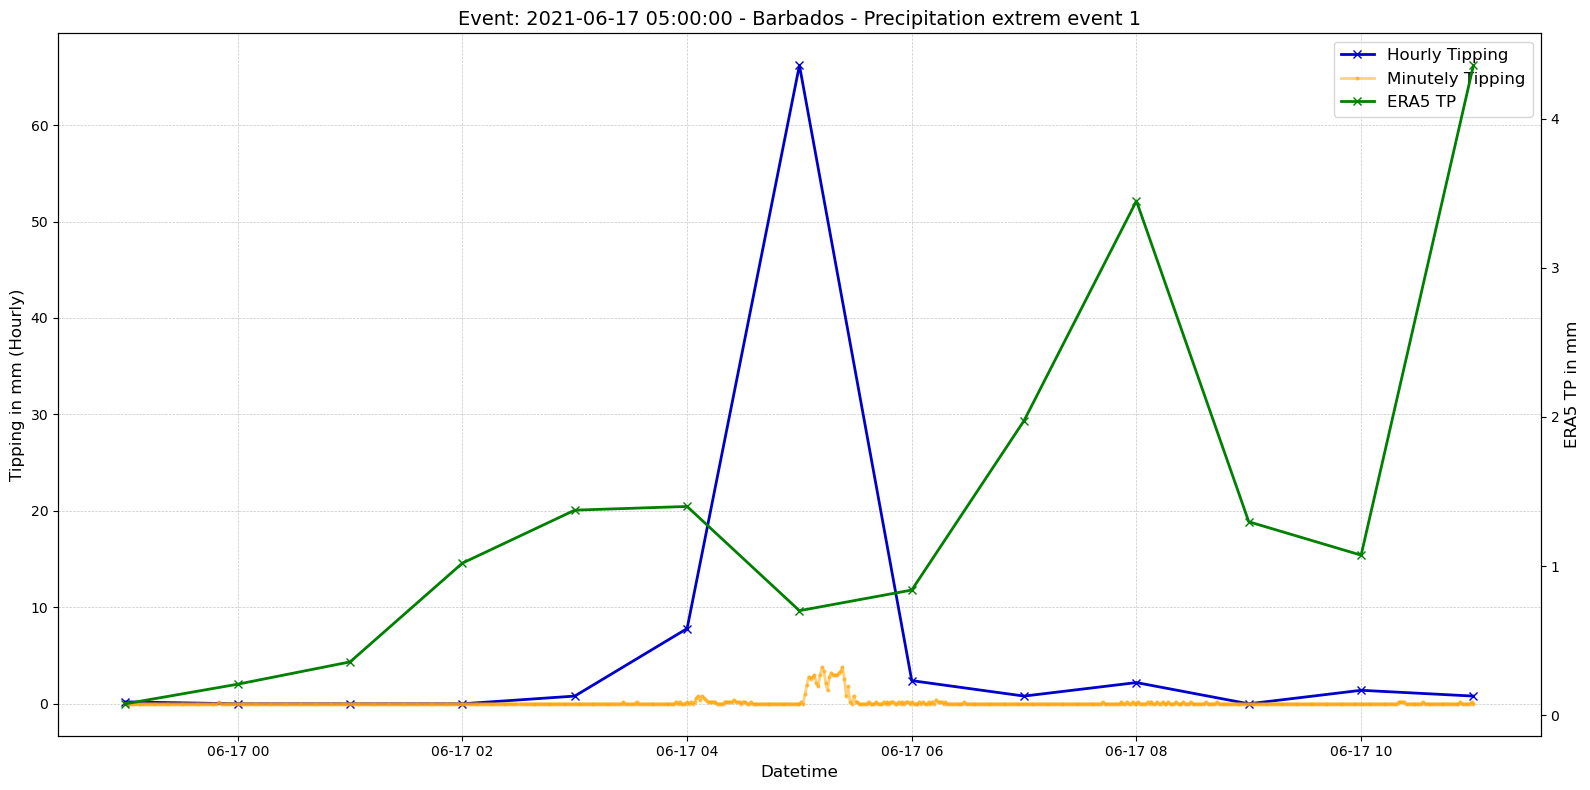

In [101]:
# Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[0])

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= False,
    title_suffix="Barbados - Precipitation extrem event 1",
    save_fig=False
)





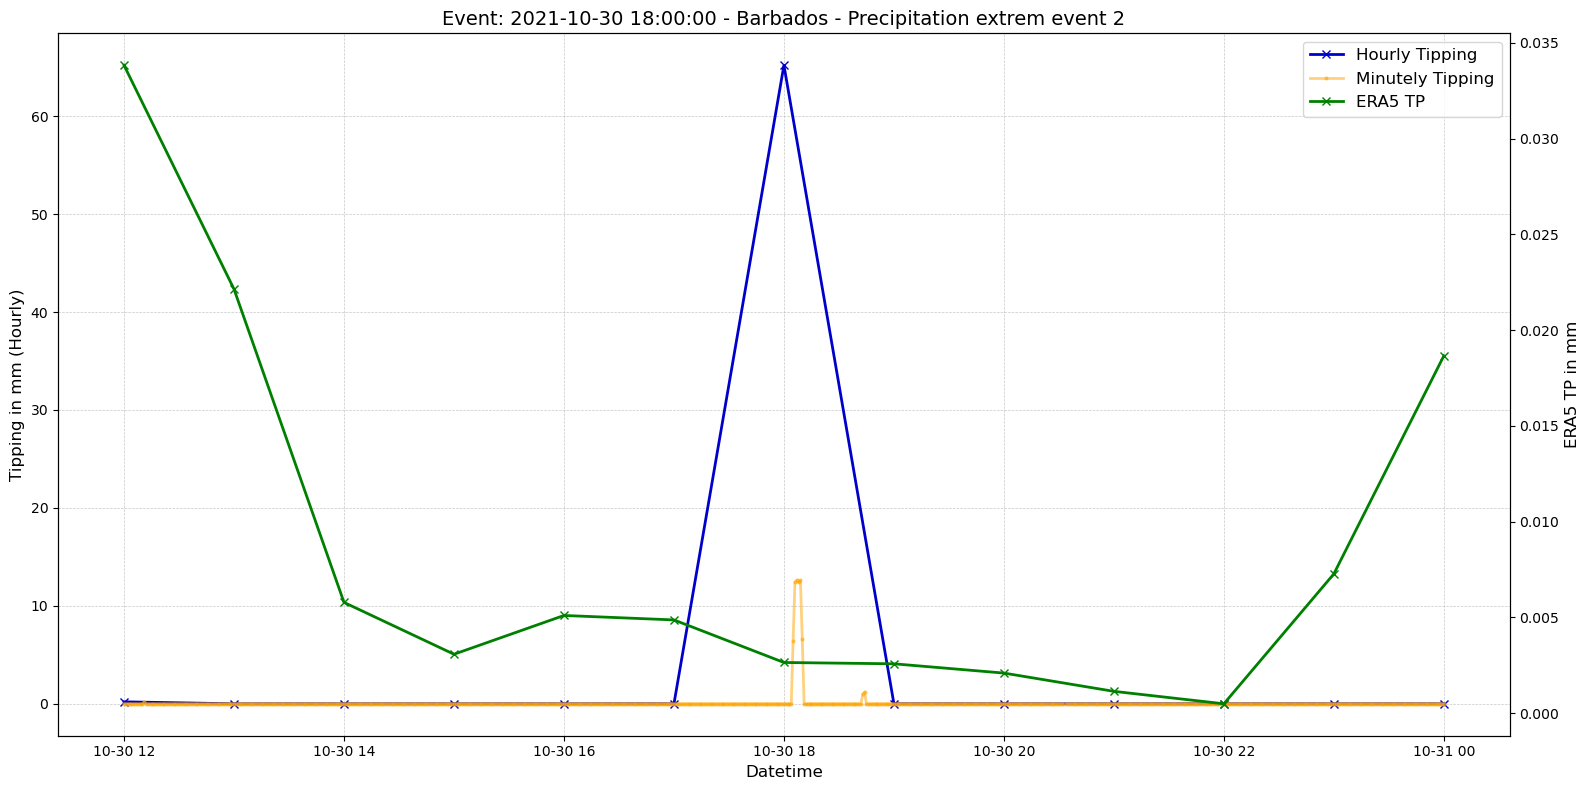

In [102]:
# Example Event 2
event_2 = pd.Timestamp(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[1])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= False,
    title_suffix="Barbados - Precipitation extrem event 2",
    save_fig=False
)



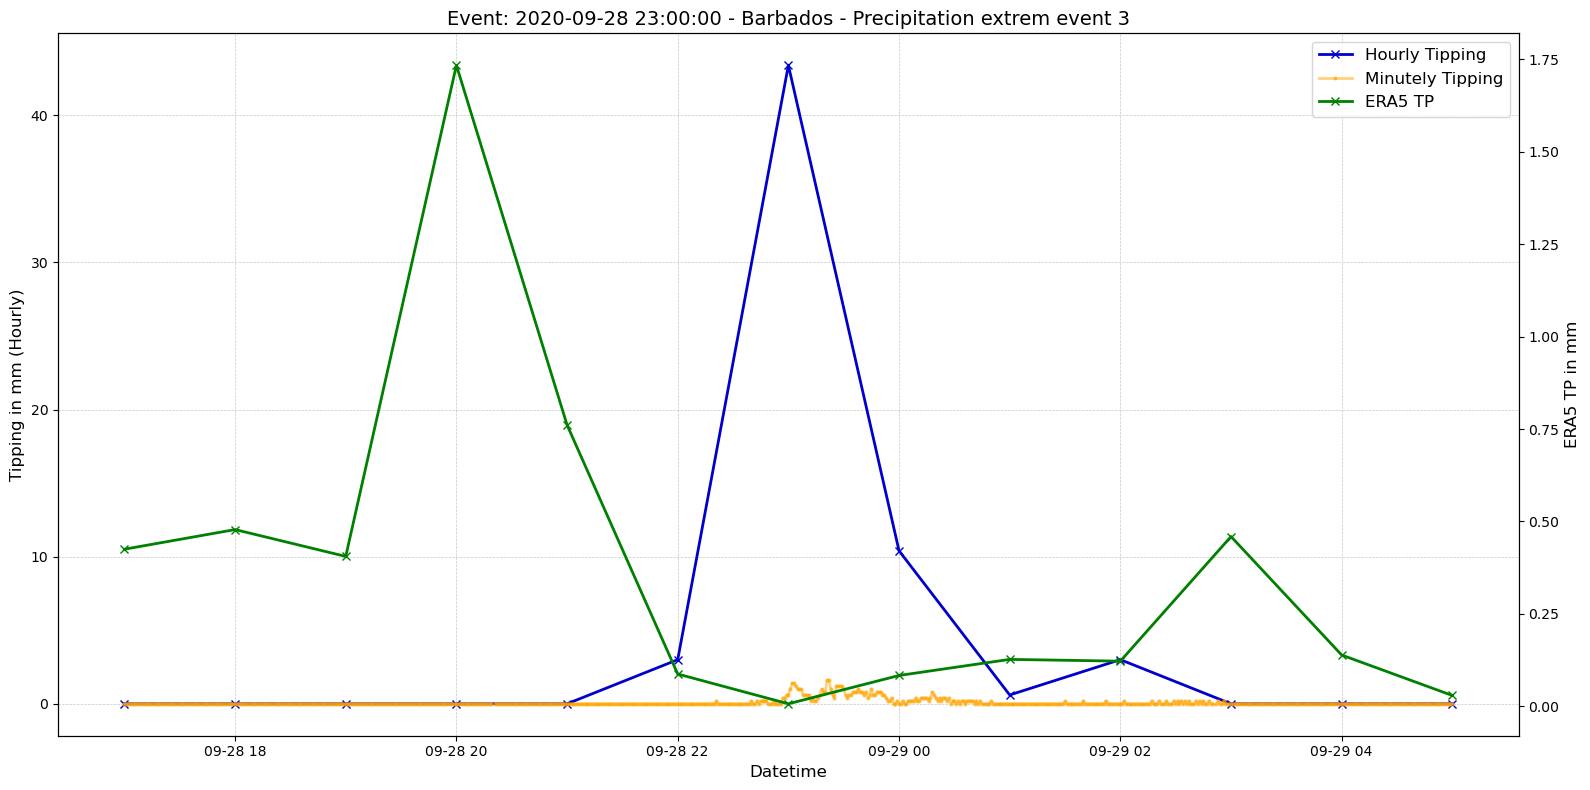

In [103]:
# Example Event 3
event_3 = pd.Timestamp(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[2])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= False,
    title_suffix="Barbados - Precipitation extrem event 3",
    save_fig=False
)



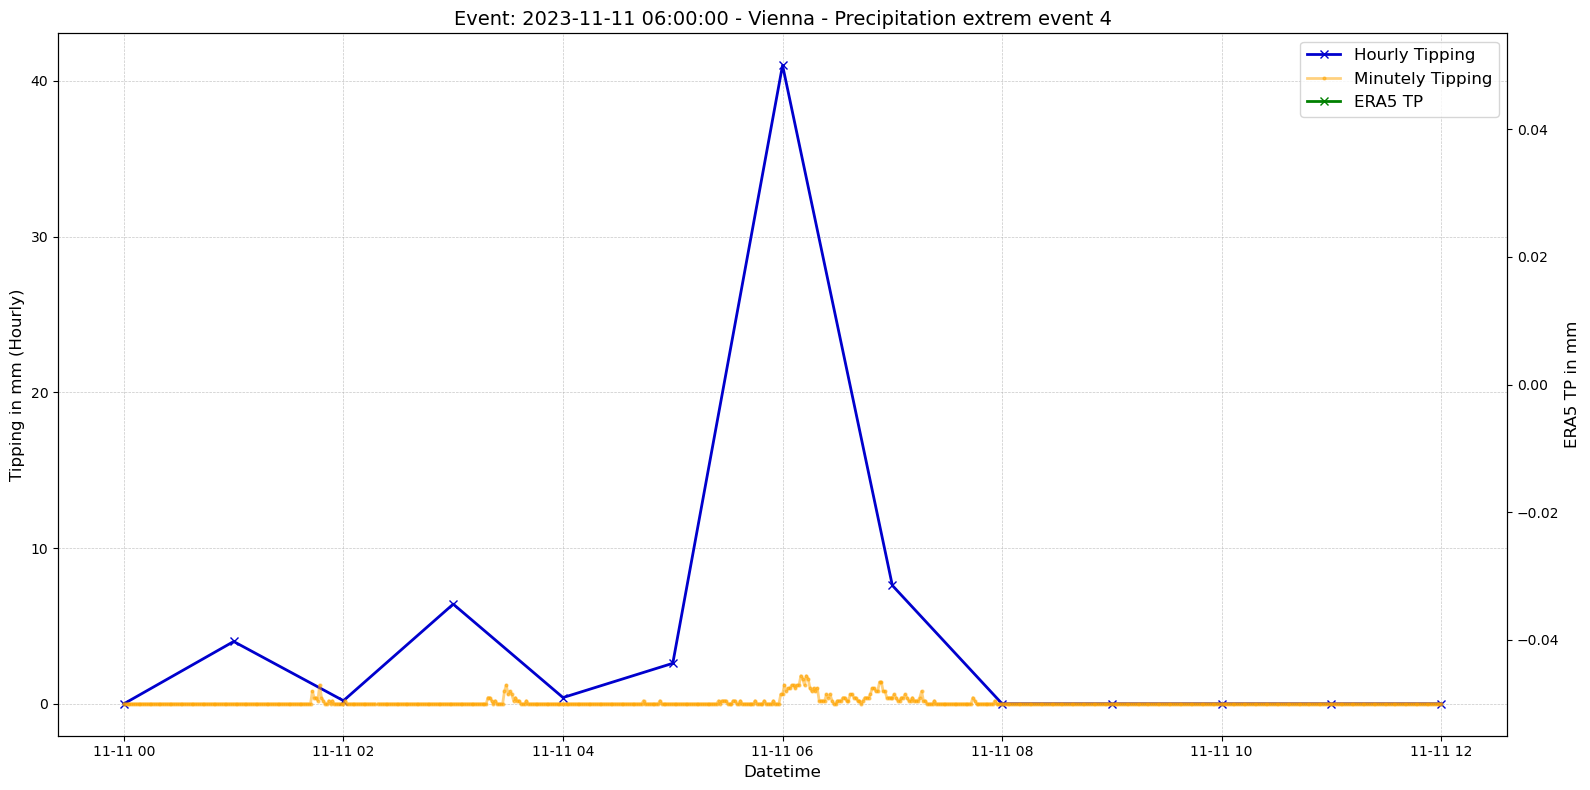

In [104]:
# Example Event 4
event_4 = pd.Timestamp(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[3])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_4,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= False,
    title_suffix="Barbados - Precipitation extrem event 4",
    save_fig=False
)


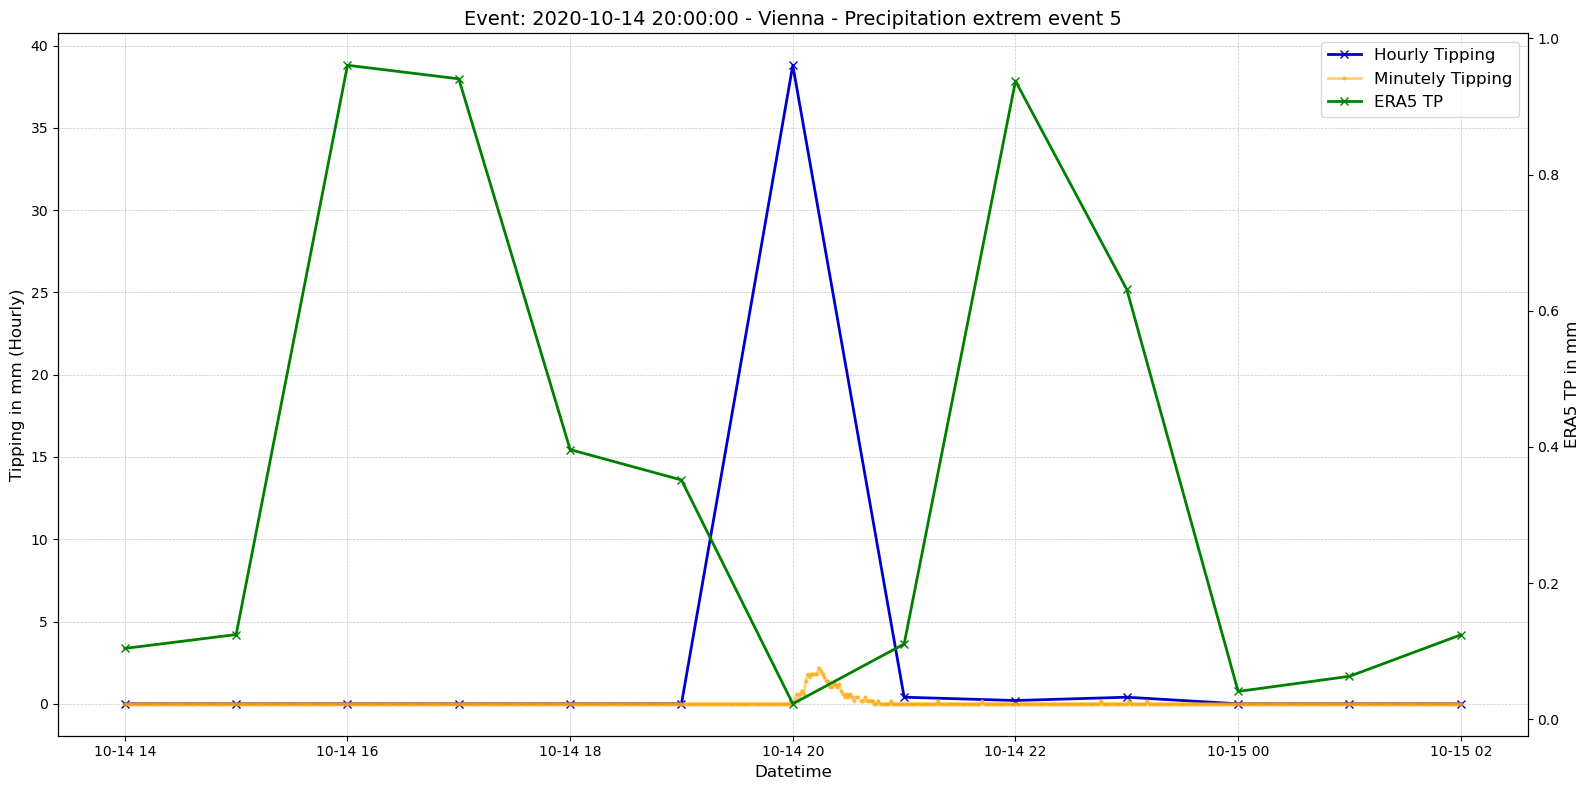

In [105]:
# Example Event 5
event_5 = pd.Timestamp(barbados_hourly_df.sort_values(by=['tipping'], ascending=False).index[4])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_5,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= False,
    title_suffix="Barbados - Precipitation extrem event 5",
    save_fig=False
)


## Wind speed

In [93]:
# 5 heaviest precipitation events
barbados_hourly_df.sort_values(by=['wind_speed'], ascending=False)


,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2022-01-24 02:00:00,23.770,984.770,1016.230,22.40,86.9,22.8,0.0,NaN,253.0,NaN,74.617241
2022-05-26 06:00:00,25.235,984.985,1016.290,16.85,NaN,24.4,0.0,260.0,253.0,NaN,59.601000
2022-04-10 18:00:00,27.240,983.820,1014.880,25.90,76.9,26.4,0.0,513.5,2820.5,137.5,56.670816
2022-11-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,55.158305
2022-05-20 02:00:00,25.550,988.490,1019.870,17.80,NaN,24.8,0.0,260.0,253.0,NaN,49.801754
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-03 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-08 07:00:00,25.350,981.555,1012.735,8.90,NaN,23.9,0.0,260.0,254.0,NaN,NaN
2023-09-08 08:00:00,25.400,982.090,1013.270,8.40,NaN,23.9,0.0,260.0,253.0,NaN,NaN


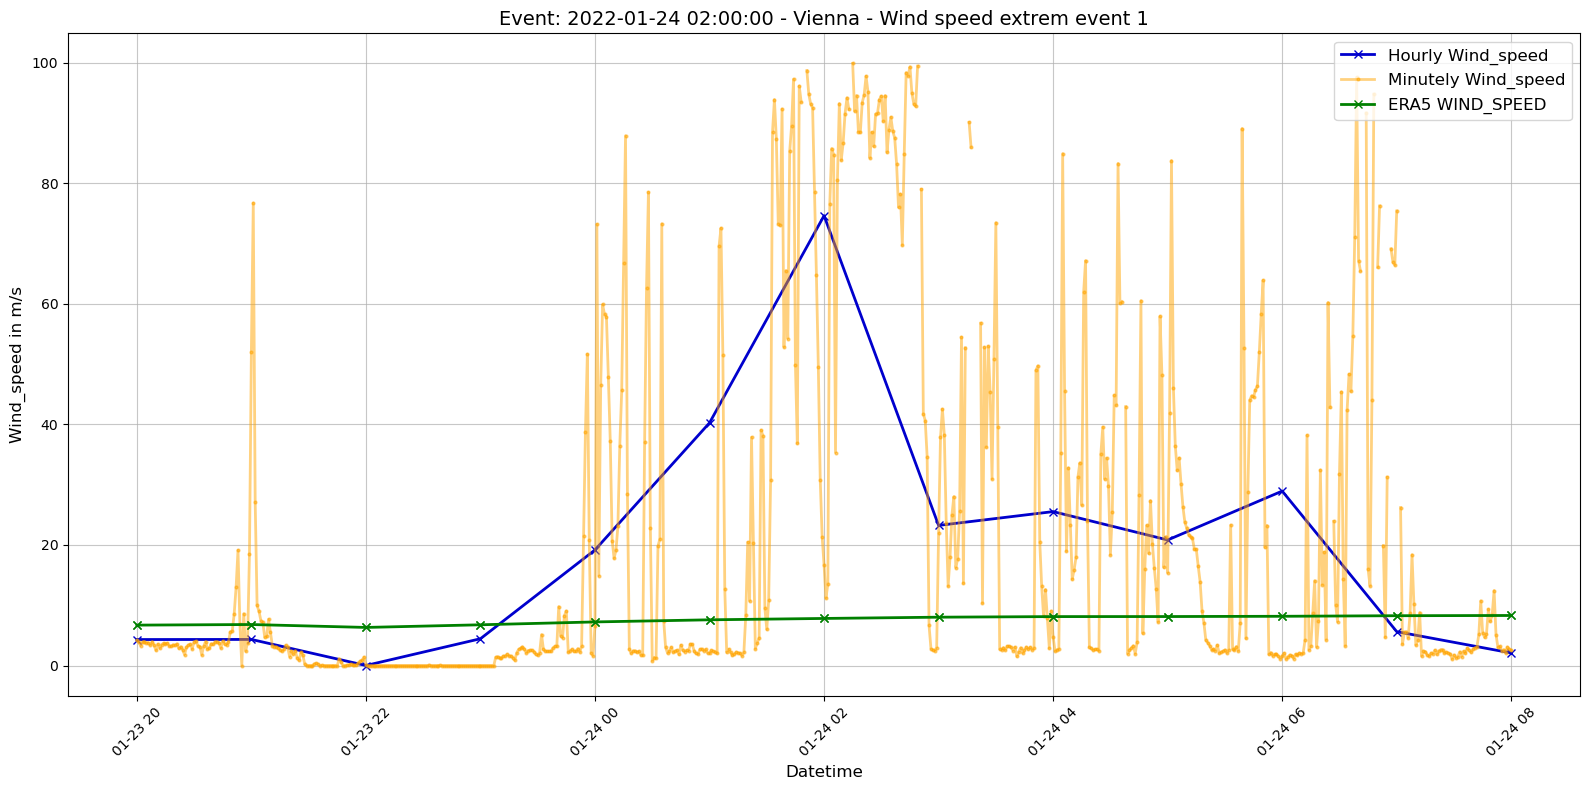

In [106]:
# Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['wind_speed'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= True,
    title_suffix="Barbados - Wind speed extrem event 1",
    save_fig=False
)

## Temperature

In [95]:
# 5 heaviest precipitation events
barbados_hourly_df.sort_values(by=['mcp9808'], ascending=False).head()


,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2023-09-28 17:00:00,33.300,980.355,1010.700,12.70,NaN,32.20,0.0,1020.5,8132.0,409.0,2.078833
2023-09-28 16:00:00,33.410,980.930,1011.275,13.10,NaN,32.20,0.0,1050.0,8305.0,425.0,2.045833
2023-09-28 15:00:00,33.250,981.650,1011.975,13.00,NaN,32.10,0.0,1160.5,9585.5,484.0,1.706333
2023-09-29 15:00:00,33.210,981.830,1012.200,12.80,NaN,32.10,0.0,1043.0,8301.0,421.5,2.366667
2023-09-28 18:00:00,33.145,979.665,1010.040,12.55,NaN,32.05,0.0,822.5,6103.5,303.0,2.094833


In [96]:
# 5 heaviest precipitation events
barbados_hourly_df.sort_values(by=['mcp9808'], ascending=True).head()


,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2022-01-09 06:00:00,21.040,987.020,1018.745,19.40,98.20,19.80,5.4,260.0,253.5,NaN,5.219667
2022-01-09 07:00:00,21.135,986.640,1018.410,19.60,97.70,19.90,2.8,260.0,253.0,NaN,5.633000
2022-01-09 00:00:00,21.475,988.680,1020.535,20.00,94.95,20.25,0.8,260.0,253.0,2.0,2.352000
2023-01-01 09:00:00,21.140,984.380,1016.110,20.35,NaN,20.40,7.4,NaN,NaN,NaN,3.379333
2022-01-11 10:00:00,21.700,985.805,1017.530,20.10,98.80,20.40,10.0,263.0,290.0,3.0,2.586667


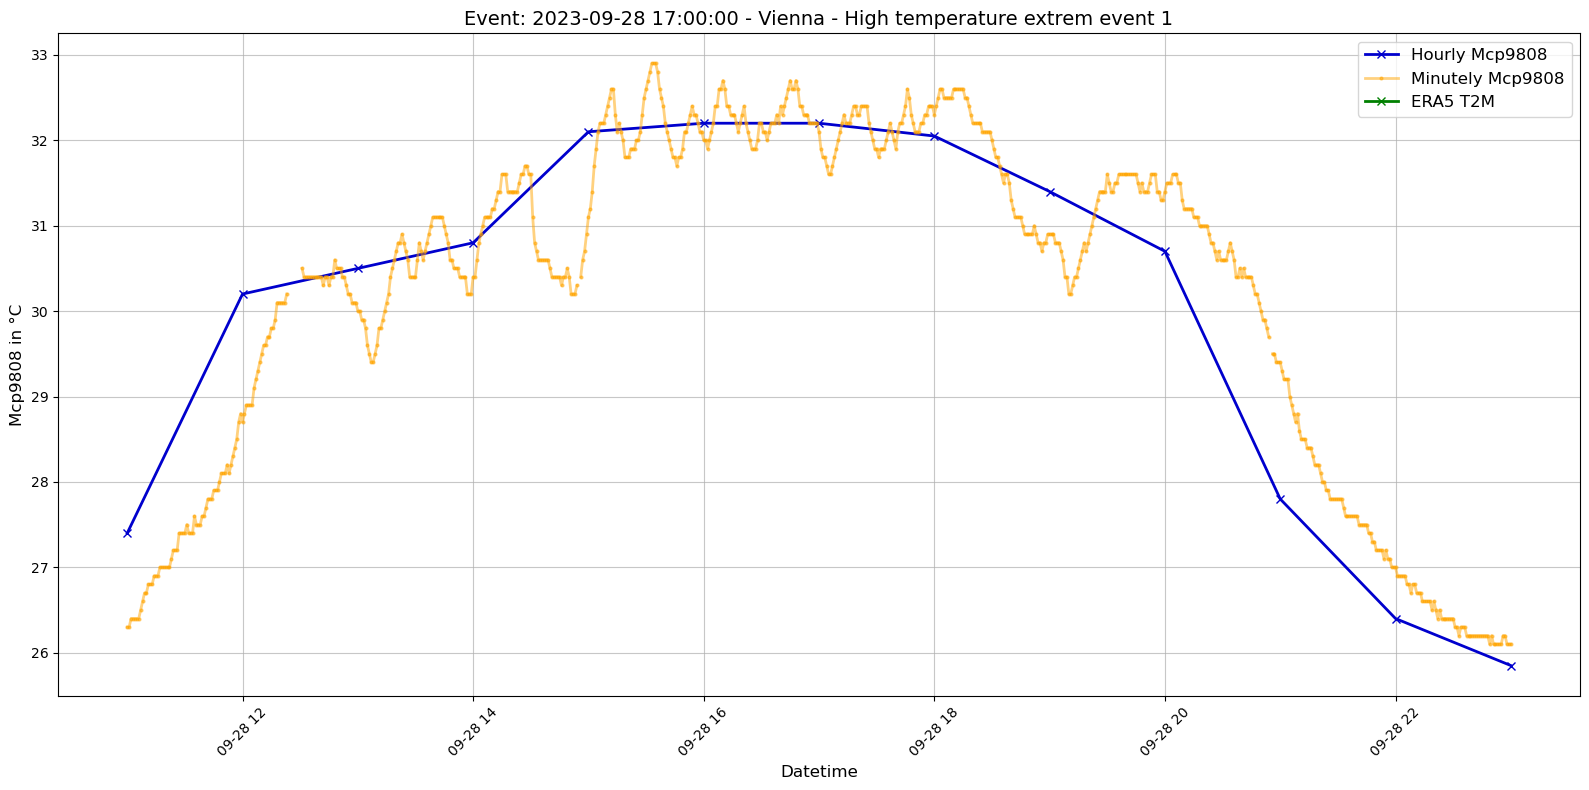

In [107]:
# Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['mcp9808'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= True,
    title_suffix="Barbados - High temperature extrem event 1",
    save_fig=False
)

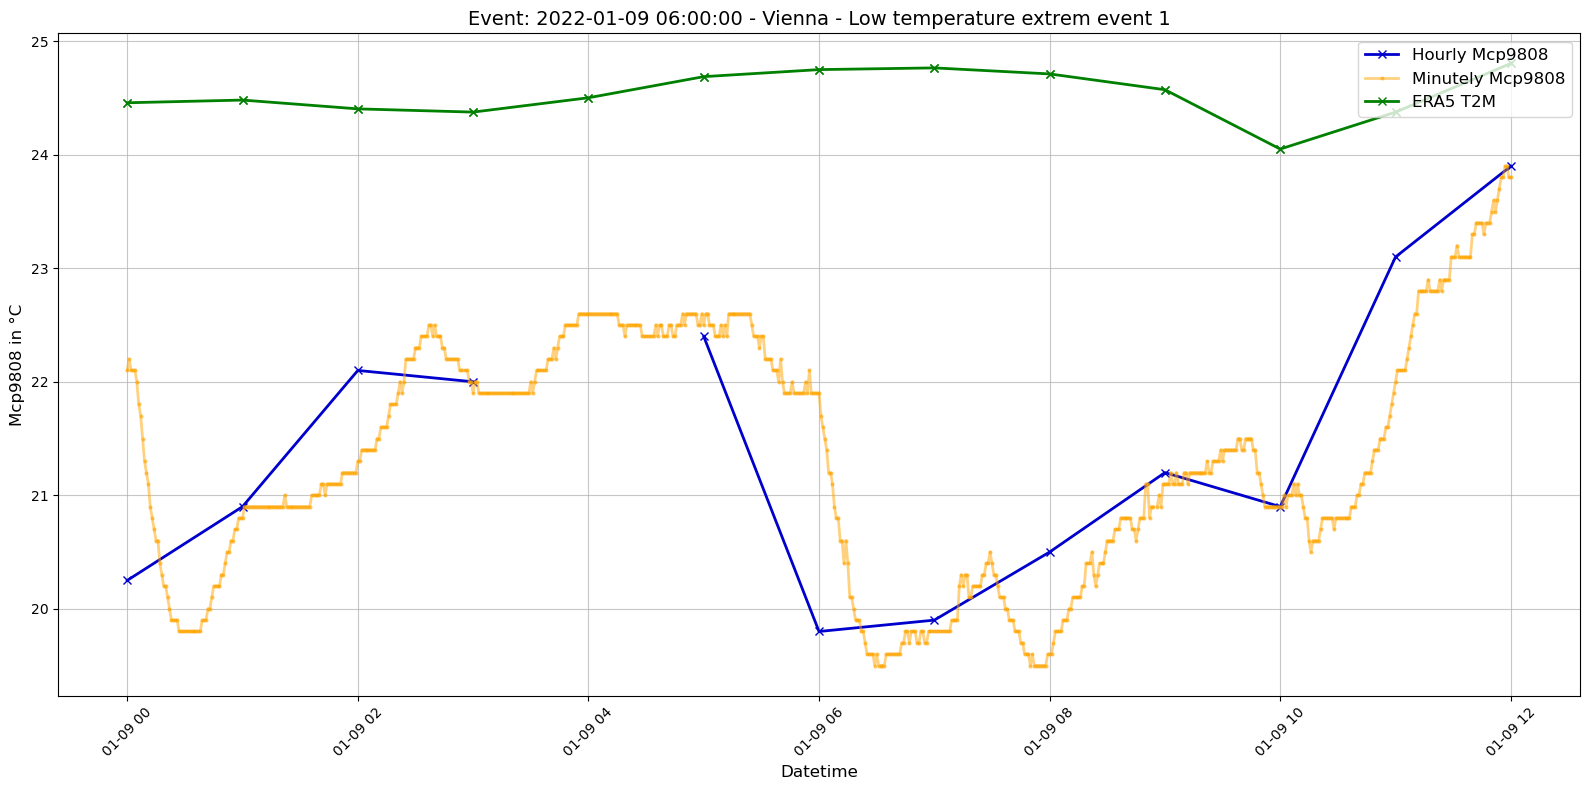

In [108]:
# Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['mcp9808'], ascending=True).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_barbados_ds,
    same_y_axis= True,
    title_suffix="Barbados - Low temperature extrem event 1",
    save_fig=False
)

## Humidity

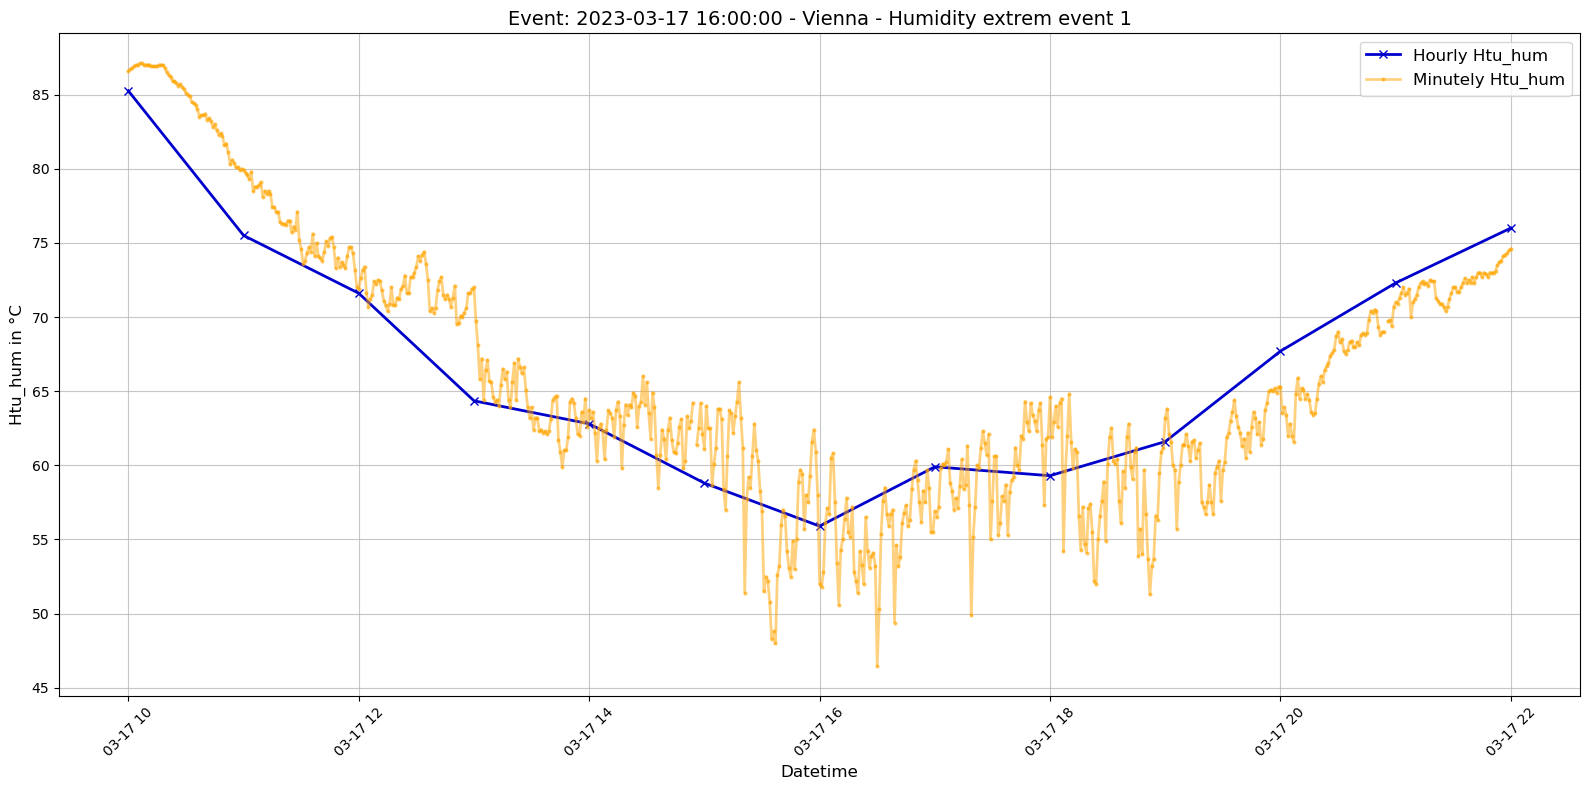

In [109]:
### Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['htu_hum'], ascending=True).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="htu_hum",       # Hourly temperature
    variable_minute="htu_hum",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    same_y_axis= True,
    title_suffix="Barbados - Humidity extrem event 1",
    save_fig=False
)

## Pressure

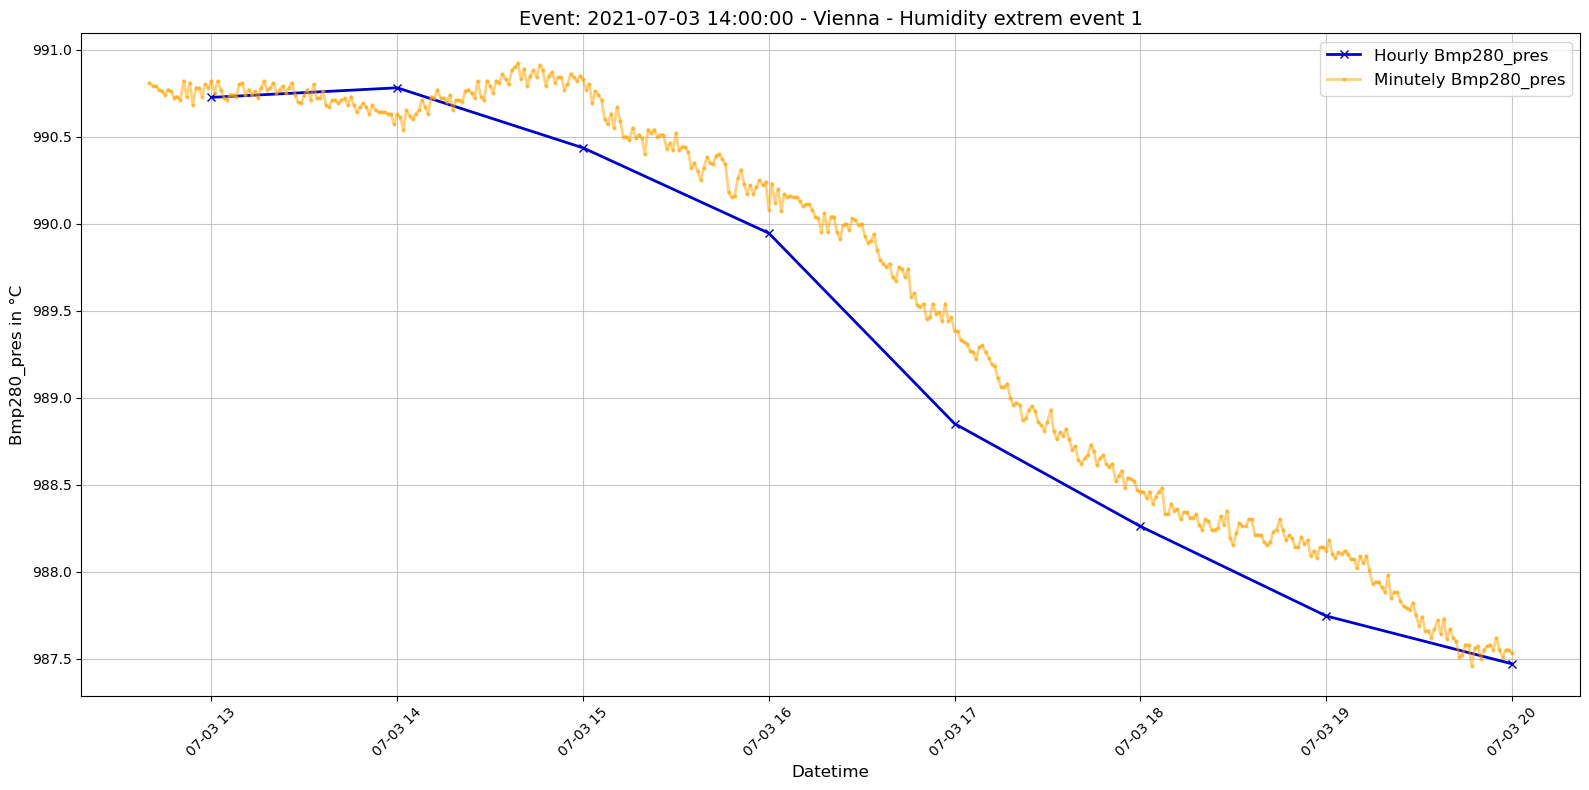

In [110]:
### Example Event 1
event_1 = pd.Timestamp(barbados_hourly_df.sort_values(by=['bmp280_pres'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    variable_hourly="bmp280_pres",       # Hourly temperature
    variable_minute="bmp280_pres",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=6),
    same_y_axis= True,
    title_suffix="Barbados - Humidity extrem event 1",
    save_fig=False
)

# Comparison to other Datasources

In [90]:
vienna_geopherestation_df.max()

station    5925.0
ff           13.4
rr           39.1
rrm          60.0
rr_flag      10.0
tl           38.5
dtype: float64

In [ ]:
vienna_processed_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0)
vienna_processed_df.index = pd.to_datetime(vienna_processed_df.index, errors='coerce')

# Apply the  aggregation
vienna_hourly_df = apply_aggregation(vienna_processed_df)

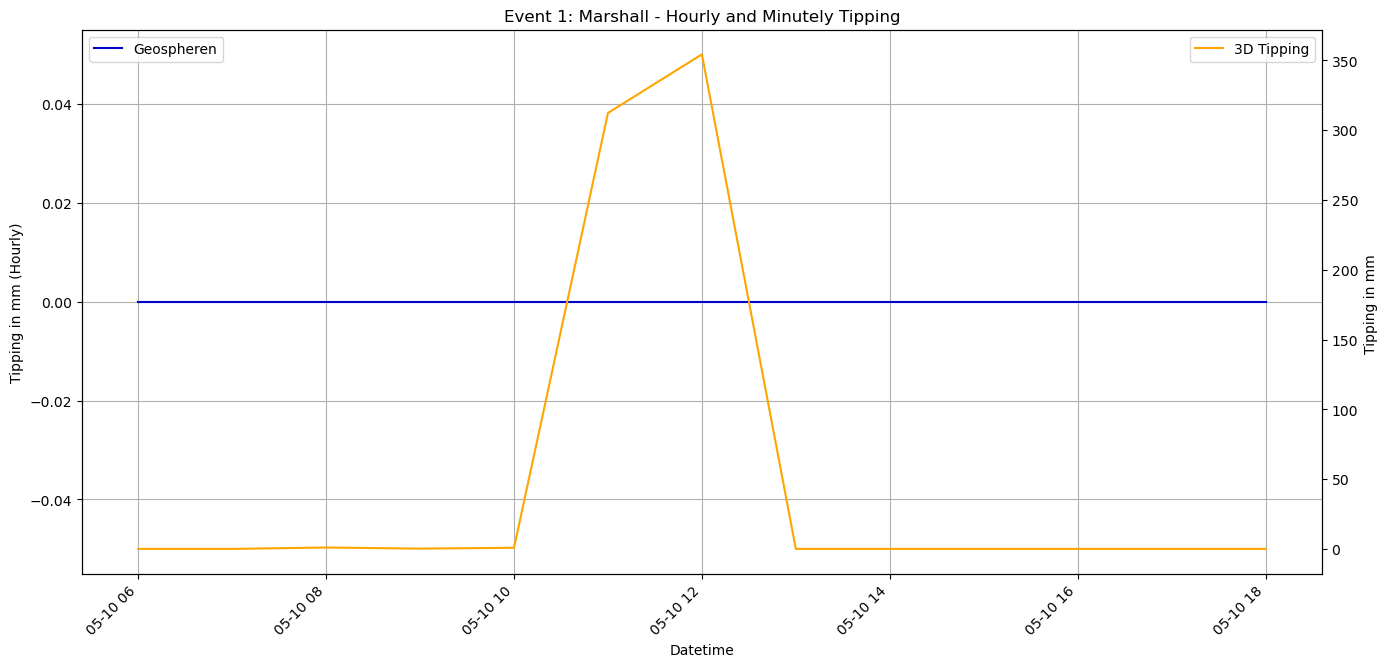

In [92]:
# Create the figure and the first axis

event_1 = pd.Timestamp("2018-05-10 12:00:00")

# measured 468 l/m2 in 1 h and the following hour measured 105 l/m2
# utc in local time 10:00

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_1 - time_delta) & (vienna_geopherestation_df.index <= event_1 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_1 - time_delta) & (vienna_hourly_df.index <= event_1 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

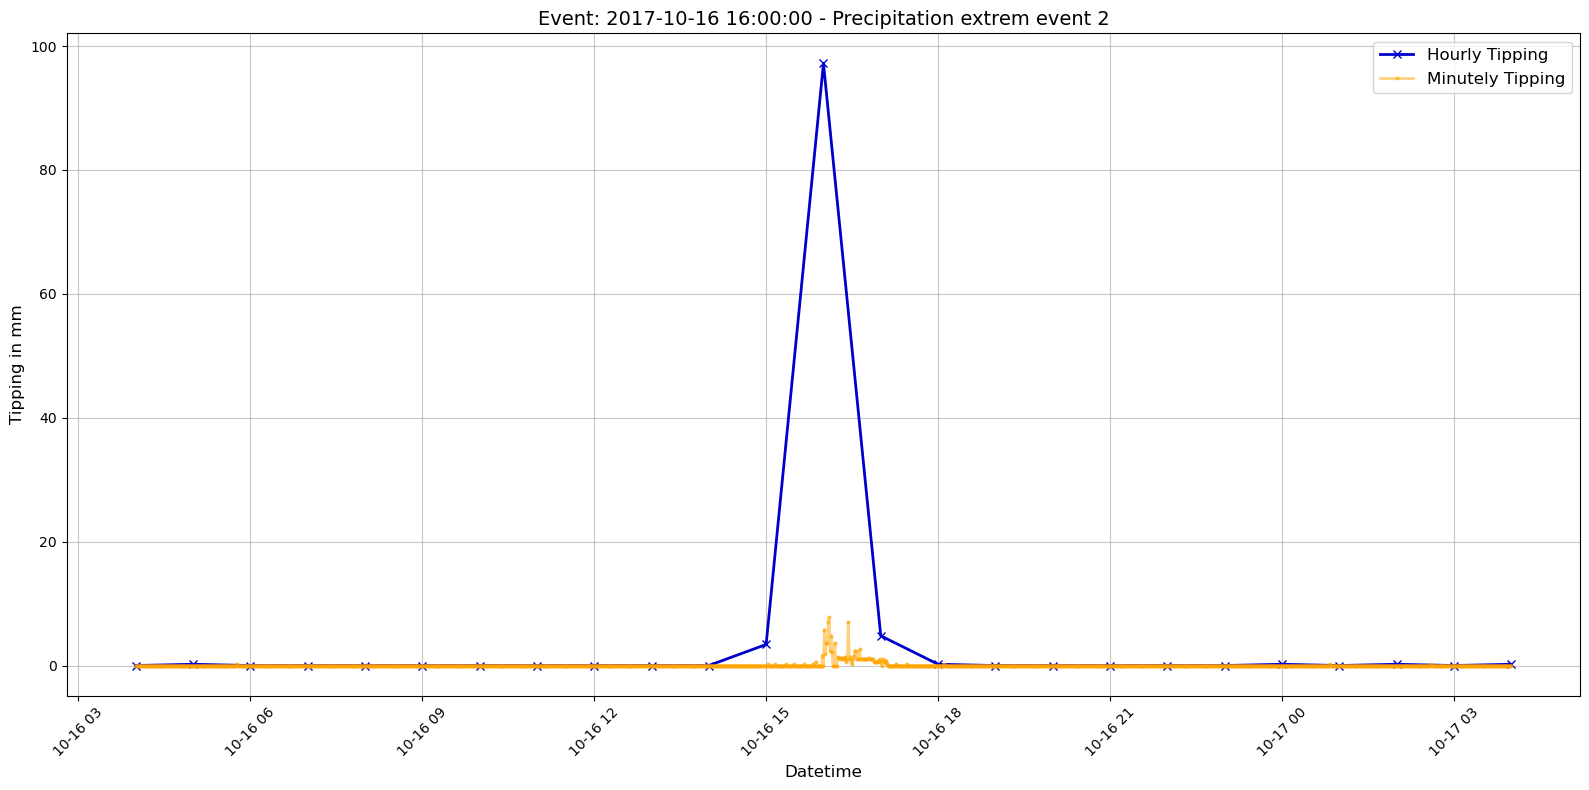

In [93]:
# Example Event 1
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 2",
    save_fig=False
)

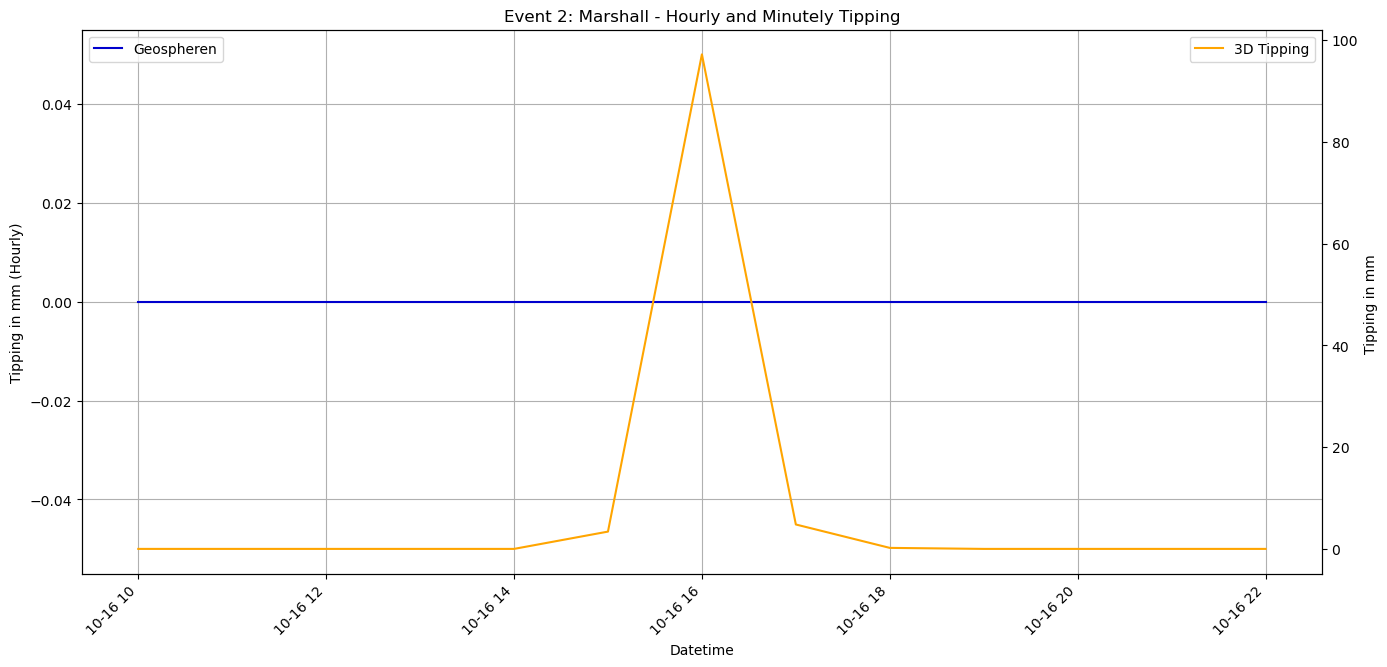

In [96]:
# Create the figure and the first axis
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_2 - time_delta) & (vienna_geopherestation_df.index <= event_2 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_2 - time_delta) & (vienna_hourly_df.index <= event_2 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

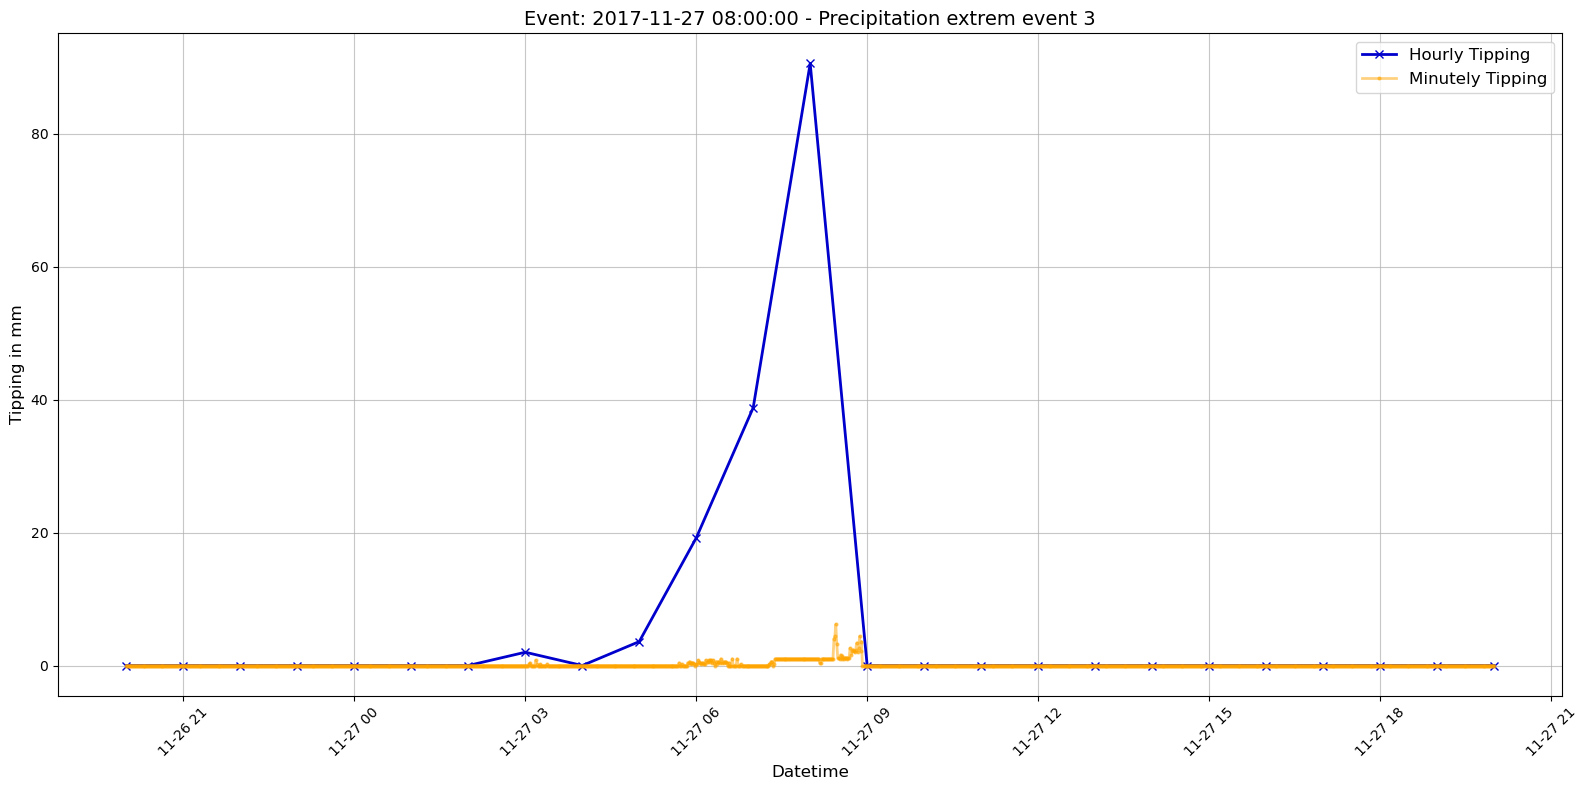

In [97]:
# Example Event 1
event_3 = pd.Timestamp("2017-11-27 08:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 3",
    save_fig=False
)

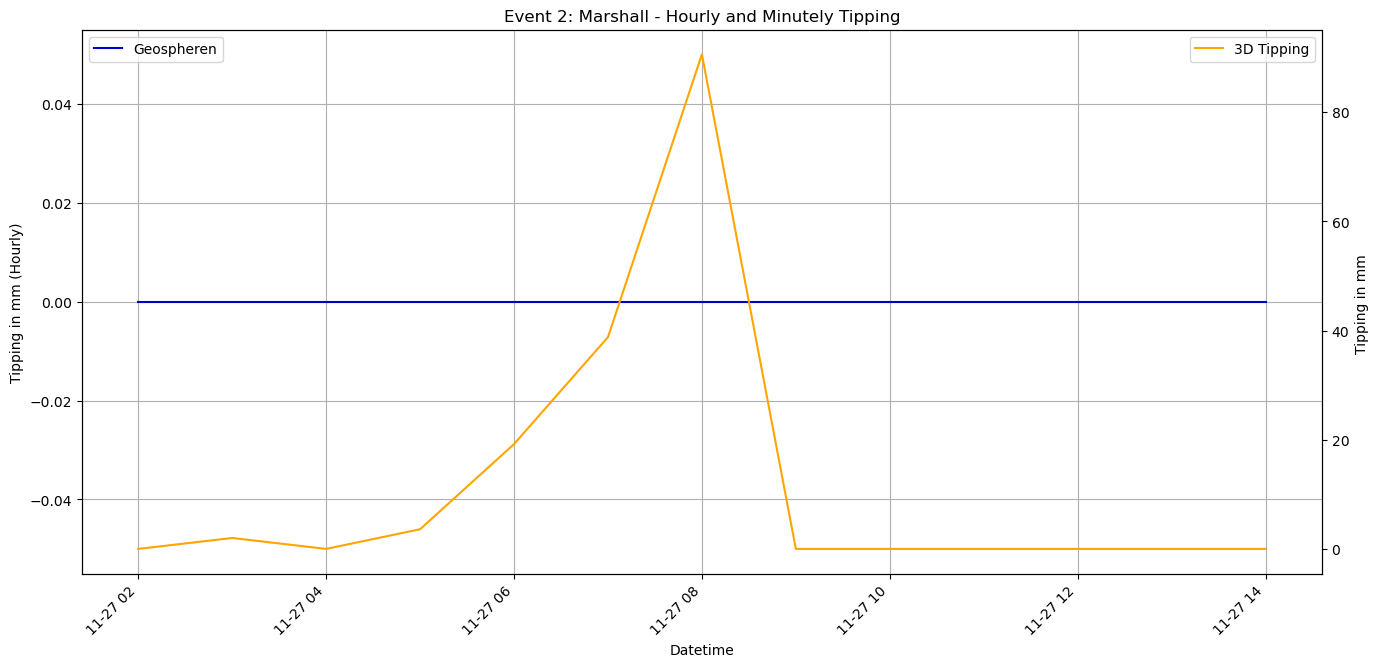

In [98]:
# Create the figure and the first axis

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_3 - time_delta) & (vienna_geopherestation_df.index <= event_3 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_3 - time_delta) & (vienna_hourly_df.index <= event_3 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()